## Objectiu: Predir si un pacient té una enfermetat cardiovascular en funció de les seves característiques clíniques.

#### ÍNDEX:

0. [Motivations](#0.-Motivations)
1. [Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)
2. [Preprocessing](#2.-Preprocessing)
3. [Metrics](#3.-Metrics)
4. [Model Selection](#4.-Model-Selection)
5. [Resultats finals](#5.-Resultats-finals)
6. [Conclusion](#6.-Conclusions)

## 0. Motivations

Les malalties cardiovasculars (CVDs) són una de les principals causes de mortalitat arreu del món, fet que les converteix en un dels grans reptes sanitaris de la nostra era. Identificar precoçment els factors de risc associats a aquestes malalties i predir quins individus podrien estar en risc és essencial per millorar la prevenció i optimitzar els recursos mèdics.

Amb l’augment de la disponibilitat de dades mèdiques i d’informació sobre els estils de vida dels pacients, el camp de l’aprenentatge computacional ofereix oportunitats úniques per desenvolupar models predictius capaços d’analitzar aquestes dades de manera eficient. Aquests models poden identificar patrons ocults i correlacions que, d’altra manera, serien difícils de detectar utilitzant mètodes tradicionals.

Aquest projecte pretén desenvolupar un model que, a partir de les característiques mèdiques dels pacients (com ara la pressió arterial, el colesterol o l’índex de massa corporal) i d’informació sobre els seus hàbits de vida (com ara el consum de tabac, l’activitat física o la dieta), permeti predir si una persona té probabilitat de patir una malaltia cardiovascular.

Les motivacions principals per realitzar aquest treball són les següents:

·Prevenció i detecció precoç: La creació d’un model predictiu pot ajudar els professionals mèdics a identificar pacients en risc abans que desenvolupin símptomes greus, millorant així la qualitat de vida i reduint la mortalitat associada.

·Optimització de recursos sanitaris: Els sistemes de salut sovint treballen sota fortes limitacions de recursos. Un model predictiu permetria prioritzar les intervencions mèdiques en aquells pacients amb un risc més alt, maximitzant l’eficiència del sistema.

·Contribució al coneixement científic: Aquest projecte pot ajudar a identificar factors de risc menys evidents que contribueixen al desenvolupament de malalties cardiovasculars, aportant informació rellevant per a la comunitat mèdica.

·Impacte social: Reduir la incidència de les malalties cardiovasculars mitjançant la personalització dels plans preventius i de tractament té un impacte directe en el benestar de les persones i de les comunitats.


En conclusió, aquest projecte combina el potencial de l’aprenentatge computacional amb l’àmbit de la salut pública per abordar un problema de gran rellevància social i científica, amb l’objectiu de millorar la qualitat de vida i reduir el pes de les malalties cardiovasculars en la societat.

### Carreguem llibreries i el dataset

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import itertools
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, KFold, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve,roc_auc_score, auc, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve 
import time
import warnings
from sklearn.exceptions import ConvergenceWarning
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

dataset = pd.read_csv(".\\cardio_train.csv", sep=";")

## 1. Exploratory Data Analysis

Explorem la nostra base de dades, entenent quines són les característiques (dades que possiblement afectin al nostre objectiu) i l'objectiu (allò que volem predir). 

In [2]:
#PRINTEM INFORMACIÓ GENERAL SOBRE EL DATASET
print(dataset.describe(), "\n")
print(dataset.dtypes)

                 id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000     10.000000   
25%    25006.750000  17664.000000      1.000000    159.000000     65.000000   
50%    50001.500000  19703.000000      1.000000    165.000000     72.000000   
75%    74889.250000  21327.000000      2.000000    170.000000     82.000000   
max    99999.000000  23713.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean     128.817286     96.630414      1.366871      1.226457      0.088129   
std      154.011419    188.472530      0.680250    

El dataset està compost de 70.000 mostres de pacients i 12 característiques (informàcio mèdica del pacient). L'objectiu que tenim serà construir un model el més precís possible per predir si un pacient té o no una malaltia cardiovascular, en funció de les seves dades mèdices i biològiques (com el sexe, l'edat, la pressió sanguínia sistòlica, etc). El nostre/s model/s realitzarà/n una tasca de **classificació**, marcant com a 0 aquells pacients que pensa que no tenen cap malaltia cardiovascular (classe negativa), o marcant com a 1 aquells pacients que pensa que tenen una malaltia cardiovascular (classe positiva).

Com que l'objectiu d'aquest treball és predir o no una enfermetat cardiovascular, tenim la intenció de minimitzar els falsos negatius (ja que fallar a l'hora d'identificar un pacient malalt -lo que seria un fals negatiu-, podria tener conseqüències molt greus, ja que començar un tractament a temps té moltes més probabilitats de salvar la vida del pacient que no si es comença tard), i també perquè és més acceptable tenir falsos positius (pacients que són diagnositcats amb una enfermetat però no la tenen realment) que no pas falsos negatius, creiem que la millor mètrica per avaluar els nostres models serà el **recall**, ja que aquesta mètrica mesura la capacitat d'un model per detectar correctament els casos positius dins de tots els casos positius reals. Sí que és veritat que hauríem d'evitar els falsos positius (pacients diagnosticats falsament), però com que el diagnòstic és una etapa inicial, un resultat positiu només porta cap a més proves, no directament cap a un tractament invasiu, per tant, és millor fallar detectant més casos suspitosos per garantir que cap malalt real no sigui detectat.

És important mencionar que el Dataset té tres tipus diferents de característiques (features):

1. Característiques objectives (informació objectiva, com el sexe, l'edat, el pes...)
2. Característiques d'examinació (resultats de proves mèdiques, com la pressió sanguínia sistòlica, els nivells de glucosa...)
3. Característiques subjectives (informació proporcionada pel pacient, com el nivell d'activitat física, la quantitat d'alcohol i de tabac que consumeix...)

Variables de la base de dades:

0. id --> Índex de les mostres. Numèric quantitatiu continu.
1. age --> Edat del pacient (dies). Numèric quantitatiu discret (encara que a vegades es classifica com a continu).
2. height --> Alçada del pacient (cm). Numèric quantitatiu continu.
3. weight --> Pes del pacient (kg). Numèric quantitatiu continu.
4. gender --> Gènere del pacient (0, 1). Categòric qualitatiu binari.
5. ap_hi --> Pressió arterial sistòlica del pacient (mmHg). Numèric quantitatiu continu.
6. ap_lo --> Pressió arterial diastòlica del pacient (mmHg). Numèric quantitatiu continu.
7. cholesterol --> Nivell de colesterol del pacient (1: normal, 2: per sobre del normal, 3: molt per sobre del normal). Categòric qualitatiu ordinal.
8. gluc --> Nivell de glucosa del pacient (1: normal, 2: per sobre del normal, 3: molt per sobre del normal). Categòric qualitatiu ordinal.
9. smoke --> Fumar o no (0: no, 1: sí). Categòric qualitatiu binari.
10. alco --> Consum d'alcohol (0: no, 1: sí). Categòric qualitatiu binari.
11. active --> Activitat física (0: no, 1: sí). Categòric qualitatiu binari.
12. cardio --> Presència o absència de malaltia cardiovascular (0: no, 1: sí). Categòric qualitatiu binari.

Tenim 12 característiques i 1 target ("cardio").

Volem predir "cardio" (presència o absència de malaltia cardiovascular en un pacient) en funció de totes les altres característiques.

Ara que ja coneixem quines són les nostres dades, podem veure que caldrà, durant l'etapa de Preprocessing, **estandaritzar** les següents columnes:

-"height"

-"weight"

-"ap_hi"

-"ap_lo"

Estandaritzarem aquestes variables perquè són numèriques contínues que tenen rangs molt amplis (la diferència entre el mínim i el màxim és molt gran, per exemple, la diferència entre els dos límits de l'interval de la variable "weight" és de 190 unitats).

Recordem que l'estandardització és important per uniformitzar les escales de les variables, millorant l'eficiència dels models basats en distàncies o gradients, com K-NN o xarxes neuronals, i permetent una penalització uniforme en models amb regularització.

In [3]:
# SEPAREM features (X) I target (y)
X=dataset.drop('cardio',axis=1)
y=dataset['cardio']

In [4]:
print("\nMostrem els primers valors de les característiques i de l'objectiu:\n")
print(X.head())


Mostrem els primers valors de les característiques i de l'objectiu:

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  
0     0       1  
1     0       1  
2     0       0  
3     0       1  
4     0       0  


In [5]:
print(y.head())

0    0
1    1
2    1
3    1
4    0
Name: cardio, dtype: int64


Anem a veure si les nostres dades presenten NaNs:

In [6]:
print("\nNombre de NaNs per columna en els features:\n")
print(X.isna().sum())
print("\nPercentatge de NaNs per columna en els features:\n")
print(X.isna().mean() * 100)


Nombre de NaNs per columna en els features:

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
dtype: int64

Percentatge de NaNs per columna en els features:

id             0.0
age            0.0
gender         0.0
height         0.0
weight         0.0
ap_hi          0.0
ap_lo          0.0
cholesterol    0.0
gluc           0.0
smoke          0.0
alco           0.0
active         0.0
dtype: float64


In [7]:
print("\nNombre de NaNs per columna en el target:\n")
print(y.isna().sum())
print("\nPercentatge de NaNs per columna en el target:\n")
print(y.isna().mean() * 100)


Nombre de NaNs per columna en el target:

0

Percentatge de NaNs per columna en el target:

0.0


No tenim NaNs (valors buits) ni en el nostre objectiu ni en les característiques.

D'altra banda, hi ha algunes característiques, concretament "age" (edat) i "height" (altura), que estan expresades en dies i centímetres, respectivament.

Si en el nostre treball fos molt important tenir un control molt específic de l'edat del pacient (per exemple, quan els pacients són nounats i tenen pocs dies de vida), llavors estaria bé tenir les dades en dies, ja que es requeriria una precisió màxima, però quan no treballem en aquests casos concrets, tenir una variable d'edat expresada en dies pot resultar en una interpretació poc intuitiva i generar problemes d'escala en alguns models. En la següent gràfica podem observar la distribució de la variable "age", expresada en anys, per saber si estem parlant de pacients nounats o de grups de pacients d'una edat concreta, o de pacients de qualsevol edat:

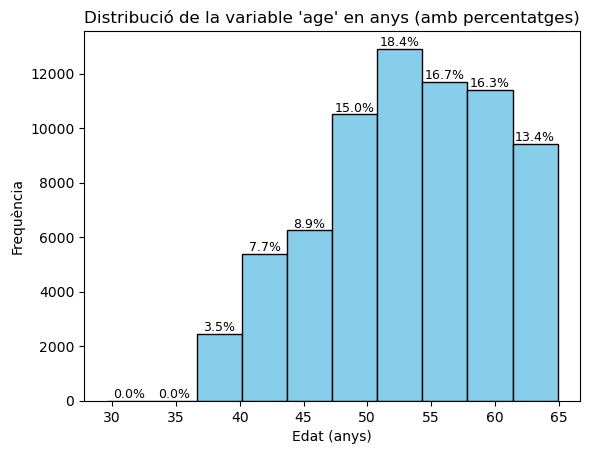

In [8]:
frequencies, bins, patches = plt.hist(X["age"]/365.25, bins=10, edgecolor='black', color='skyblue', density=False)
percentages = (frequencies / frequencies.sum()) * 100
for i in range(len(patches)):
    plt.text(
        patches[i].get_x() + patches[i].get_width() / 2,
        patches[i].get_height(),                         
        f"{percentages[i]:.1f}%",                        
        ha='center', va='bottom', fontsize=9, color='black'
    )
plt.title("Distribució de la variable 'age' en anys (amb percentatges)")
plt.xlabel("Edat (anys)")
plt.ylabel("Frequència")
plt.show()

Com podem observar, el número de pacients no es concentra en grups d'edats molt específics, i per tant no necessitem tenir tanta precisió en la variable "age".

Per tant, quan arribem a la fase de preprocessing, haurem d'expresar aquesta variable en una altra unitat, que serà els "anys", ja que és la unitat per defecte en els anàlisis mèdics.

També podem examinar la distribució de la variable "height":

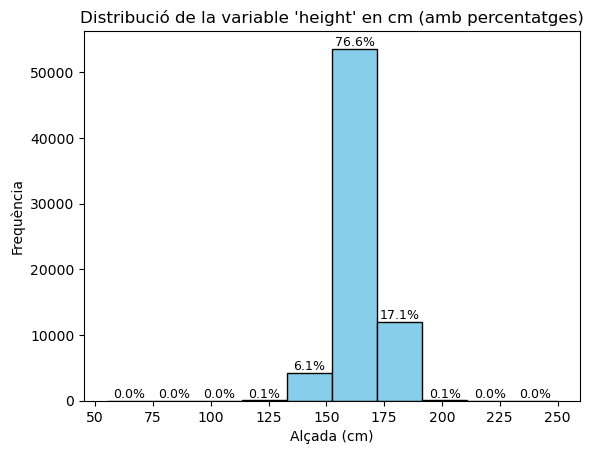

In [9]:
frequencies, bins, patches = plt.hist(X["height"], bins=10, edgecolor='black', color='skyblue', density=False)
percentages = (frequencies / frequencies.sum()) * 100
for i in range(len(patches)):
    plt.text(
        patches[i].get_x() + patches[i].get_width() / 2,
        patches[i].get_height(),                         
        f"{percentages[i]:.1f}%",                        
        ha='center', va='bottom', fontsize=9, color='black'
    )
plt.title("Distribució de la variable 'height' en cm (amb percentatges)")
plt.xlabel("Alçada (cm)")
plt.ylabel("Frequència")
plt.show()

Aquí sí que observem que la variable "height" està concentrada en grups de valors específics, sobretot en el grup d'entre 150 i 175 centímetres (76.6% de les mostres). En aquest cas sí que seria interessant tenir els valors expresats en una unitat que permeti als models tenir sensibilitat als petits canvis que hi hagi en les diferents mostres, per tant, deixarem la variable alçada expresada en centímetres, en lloc d'expresar-la en metres (que és la unitat estàndard).

A més a més, és normal que en dades clíniques s'utilitzi com a unitat de l'alçada els centímetres.

#### DISTRIBUCIONS:

Ara anem a veure les distribucions de totes les variables del nostre dataset globalment:

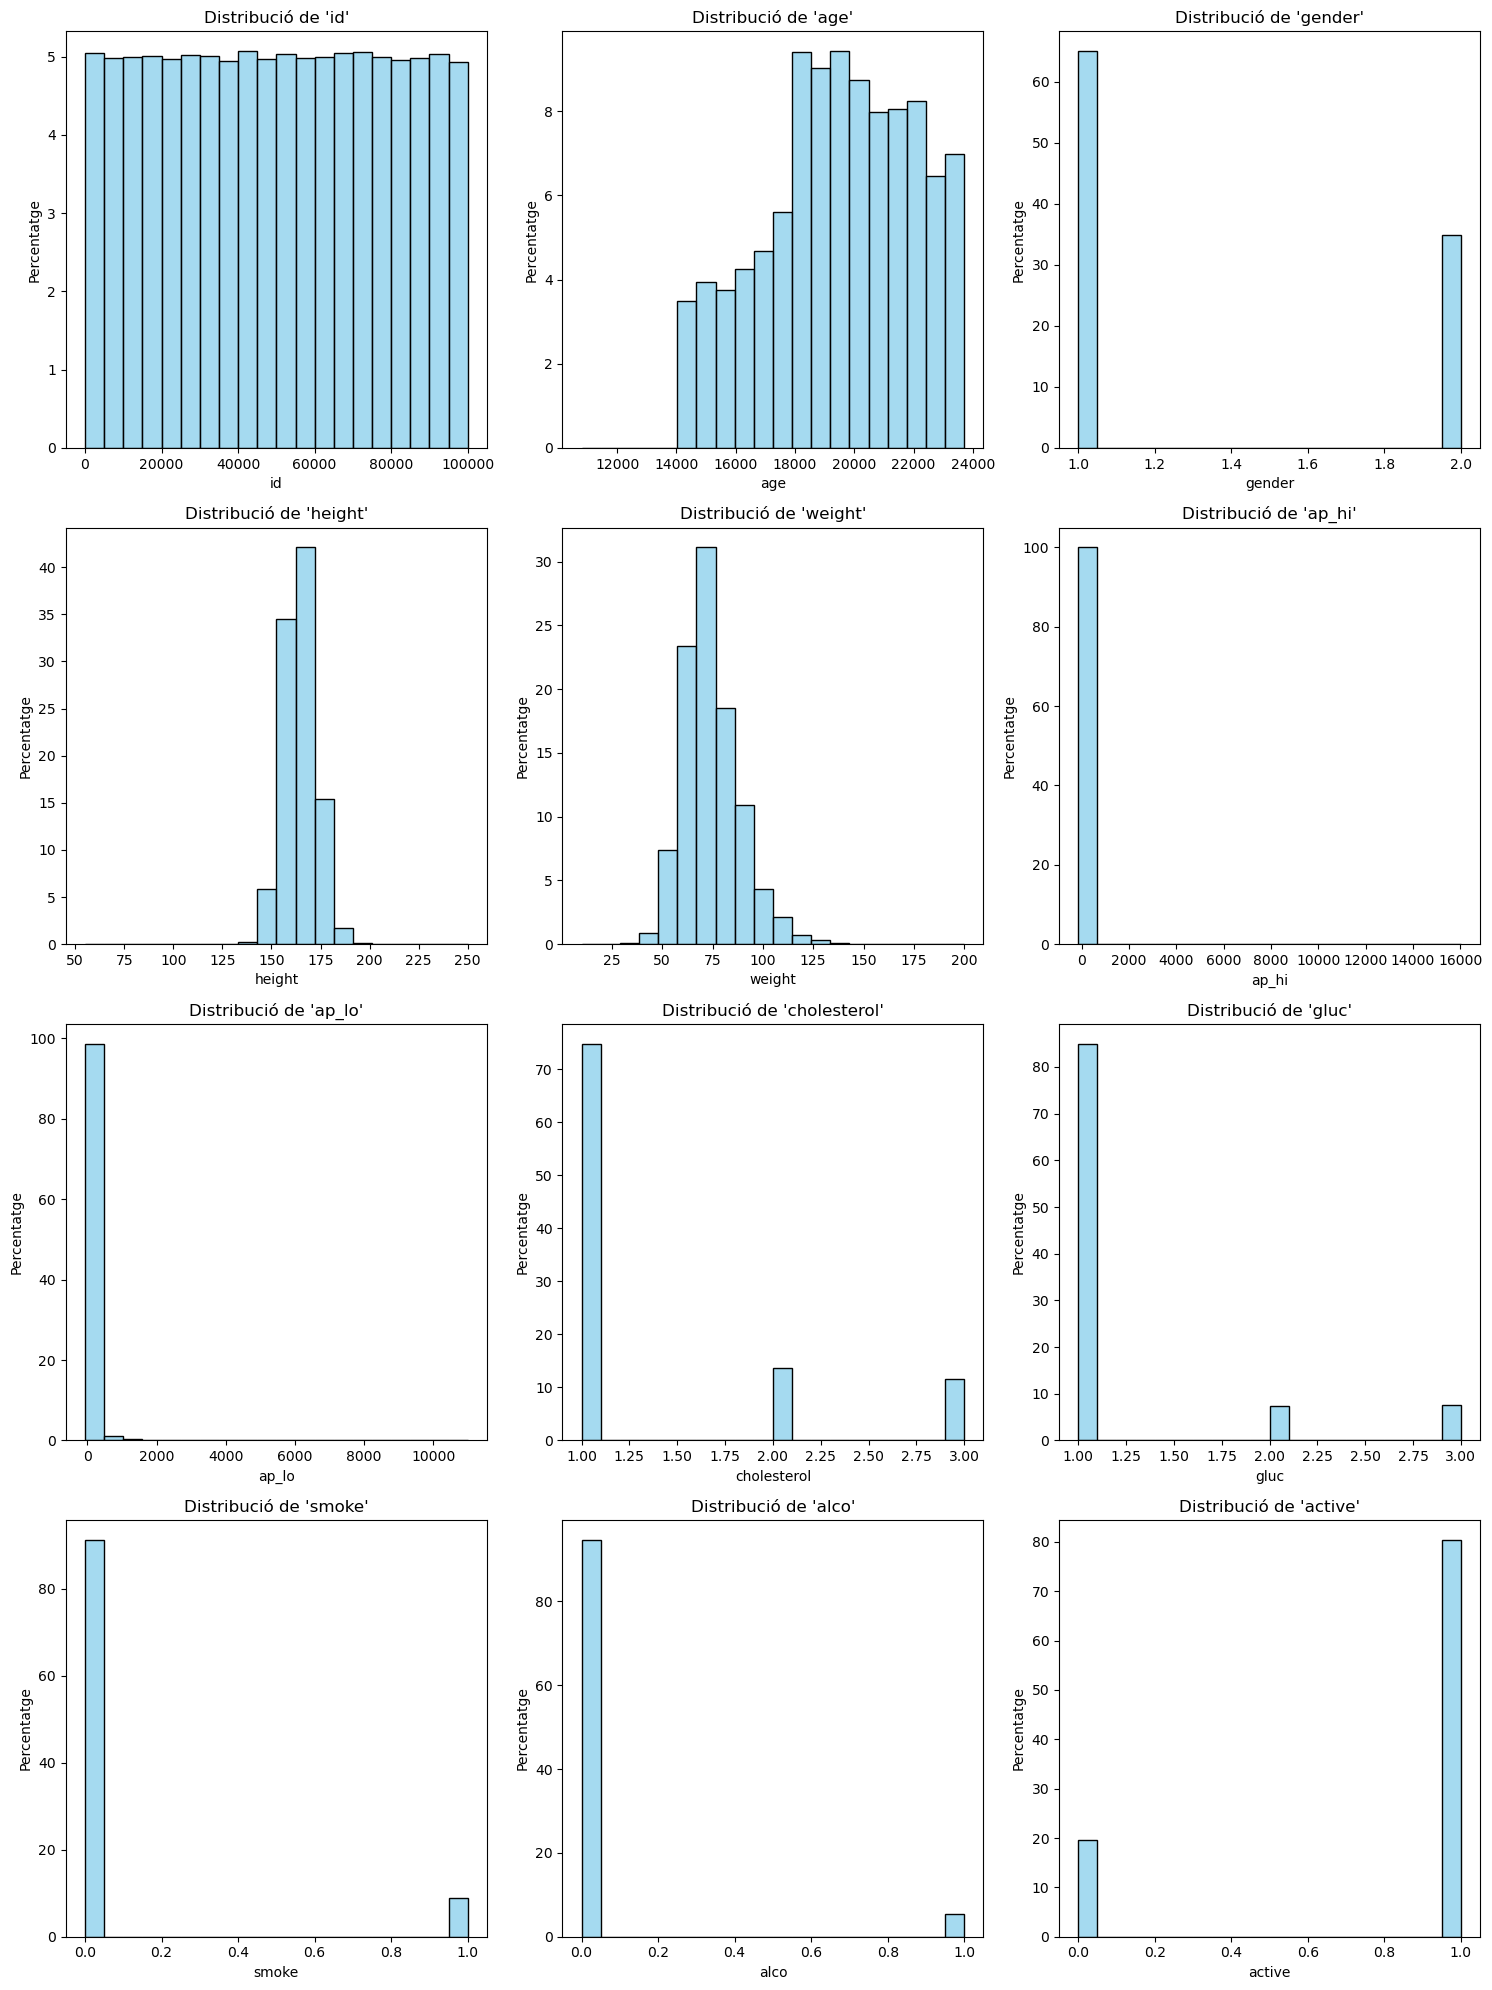

In [10]:
n_cols = 3
n_rows = len(X.columns) // n_cols + (len(X.columns) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, column in enumerate(X.columns):
    sns.histplot(X[column], kde=False, bins=20, stat="percent", color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f"Distribució de '{column}'")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Percentatge")

for i in range(len(X.columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Podem observar que hi ha variables categòriques desbalancejades, com "smoke", "cholesterol", "gender", "alco", "active" o "gluc". Per tant, podria ser interessant aplicar SMOTE o alguna altra tècnica de balanceig de dades quan arribem a la part de preprocessing. Per comprovar si és realment necessari aplicar una tècnica de balanceig de dades, podem observar la relació que té cada classe amb el target: si totes les classes de cada variable desbalancejada tenen una relació similar amb el target, el desbalanceig podria no ser problemàtic, però si les classes minoritàries tenen un patró diferent, és important corregir els desbalanceig.

In [11]:
print(pd.crosstab(X['smoke'], y, normalize='index'), "\n")
print(pd.crosstab(X['cholesterol'], y, normalize='index'), "\n")
print(pd.crosstab(X['gender'], y, normalize='index'), "\n")
print(pd.crosstab(X['alco'], y, normalize='index'), "\n")
print(pd.crosstab(X['active'], y, normalize='index'), "\n")
print(pd.crosstab(X['gluc'], y, normalize='index'), "\n")

cardio         0         1
smoke                     
0       0.497893  0.502107
1       0.525207  0.474793 

cardio              0         1
cholesterol                    
1            0.559893  0.440107
2            0.397843  0.602157
3            0.234565  0.765435 

cardio         0         1
gender                    
1       0.503273  0.496727
2       0.494769  0.505231 

cardio         0         1
alco                      
0       0.499426  0.500574
1       0.515675  0.484325 

cardio         0         1
active                    
0       0.464226  0.535774
1       0.509109  0.490891 

cardio         0         1
gluc                      
1       0.519410  0.480590
2       0.406936  0.593064
3       0.377978  0.622022 



Com podem observar, totes les variables excepte "cholesterol" i "gluc" tenen classes que, encara que estiguin desbalancejades, tenen un impacte similar en el target. Altrament, "cholesterol" i "gluc" tenen classes amb un impacte significatiu en el target: per exemple, tenir un colesterol molt alt ("cholesterol"=3, que és una classe minoritària) implica una probabilitat del 76% de tenir una malaltia cardiovascular, mentre que un colesterol baix ("cholesterol"=1) implica una probabilitat del 44% de tenir una malaltia cardiovascular (en el nostre dataset). Passa el mateix amb la variable "gluc".

Per tant, per aquestes dues variables hauríem d'aplicar alguna tècnica de balanceig, com SMOTE o simple resampling. És important fer-ho perquè les classes minoritàrias contenen informació que pot ser crucial per predir el target. Si aquestes classes estan subrepresentades en les dades, el model pot no aprendre correctament el seu impacte en la predicció, perquè no les podrà "estudiar" tant com si ho farà amb les classes superrepresentades.

D'altra banda, sembla ser que hi ha variables amb valors molt extrems, com "ap_hi" o "ap_Io". Anem a mostrar ara les distribucions amb mapes de punts (scatters), per veure-ho més clarament:

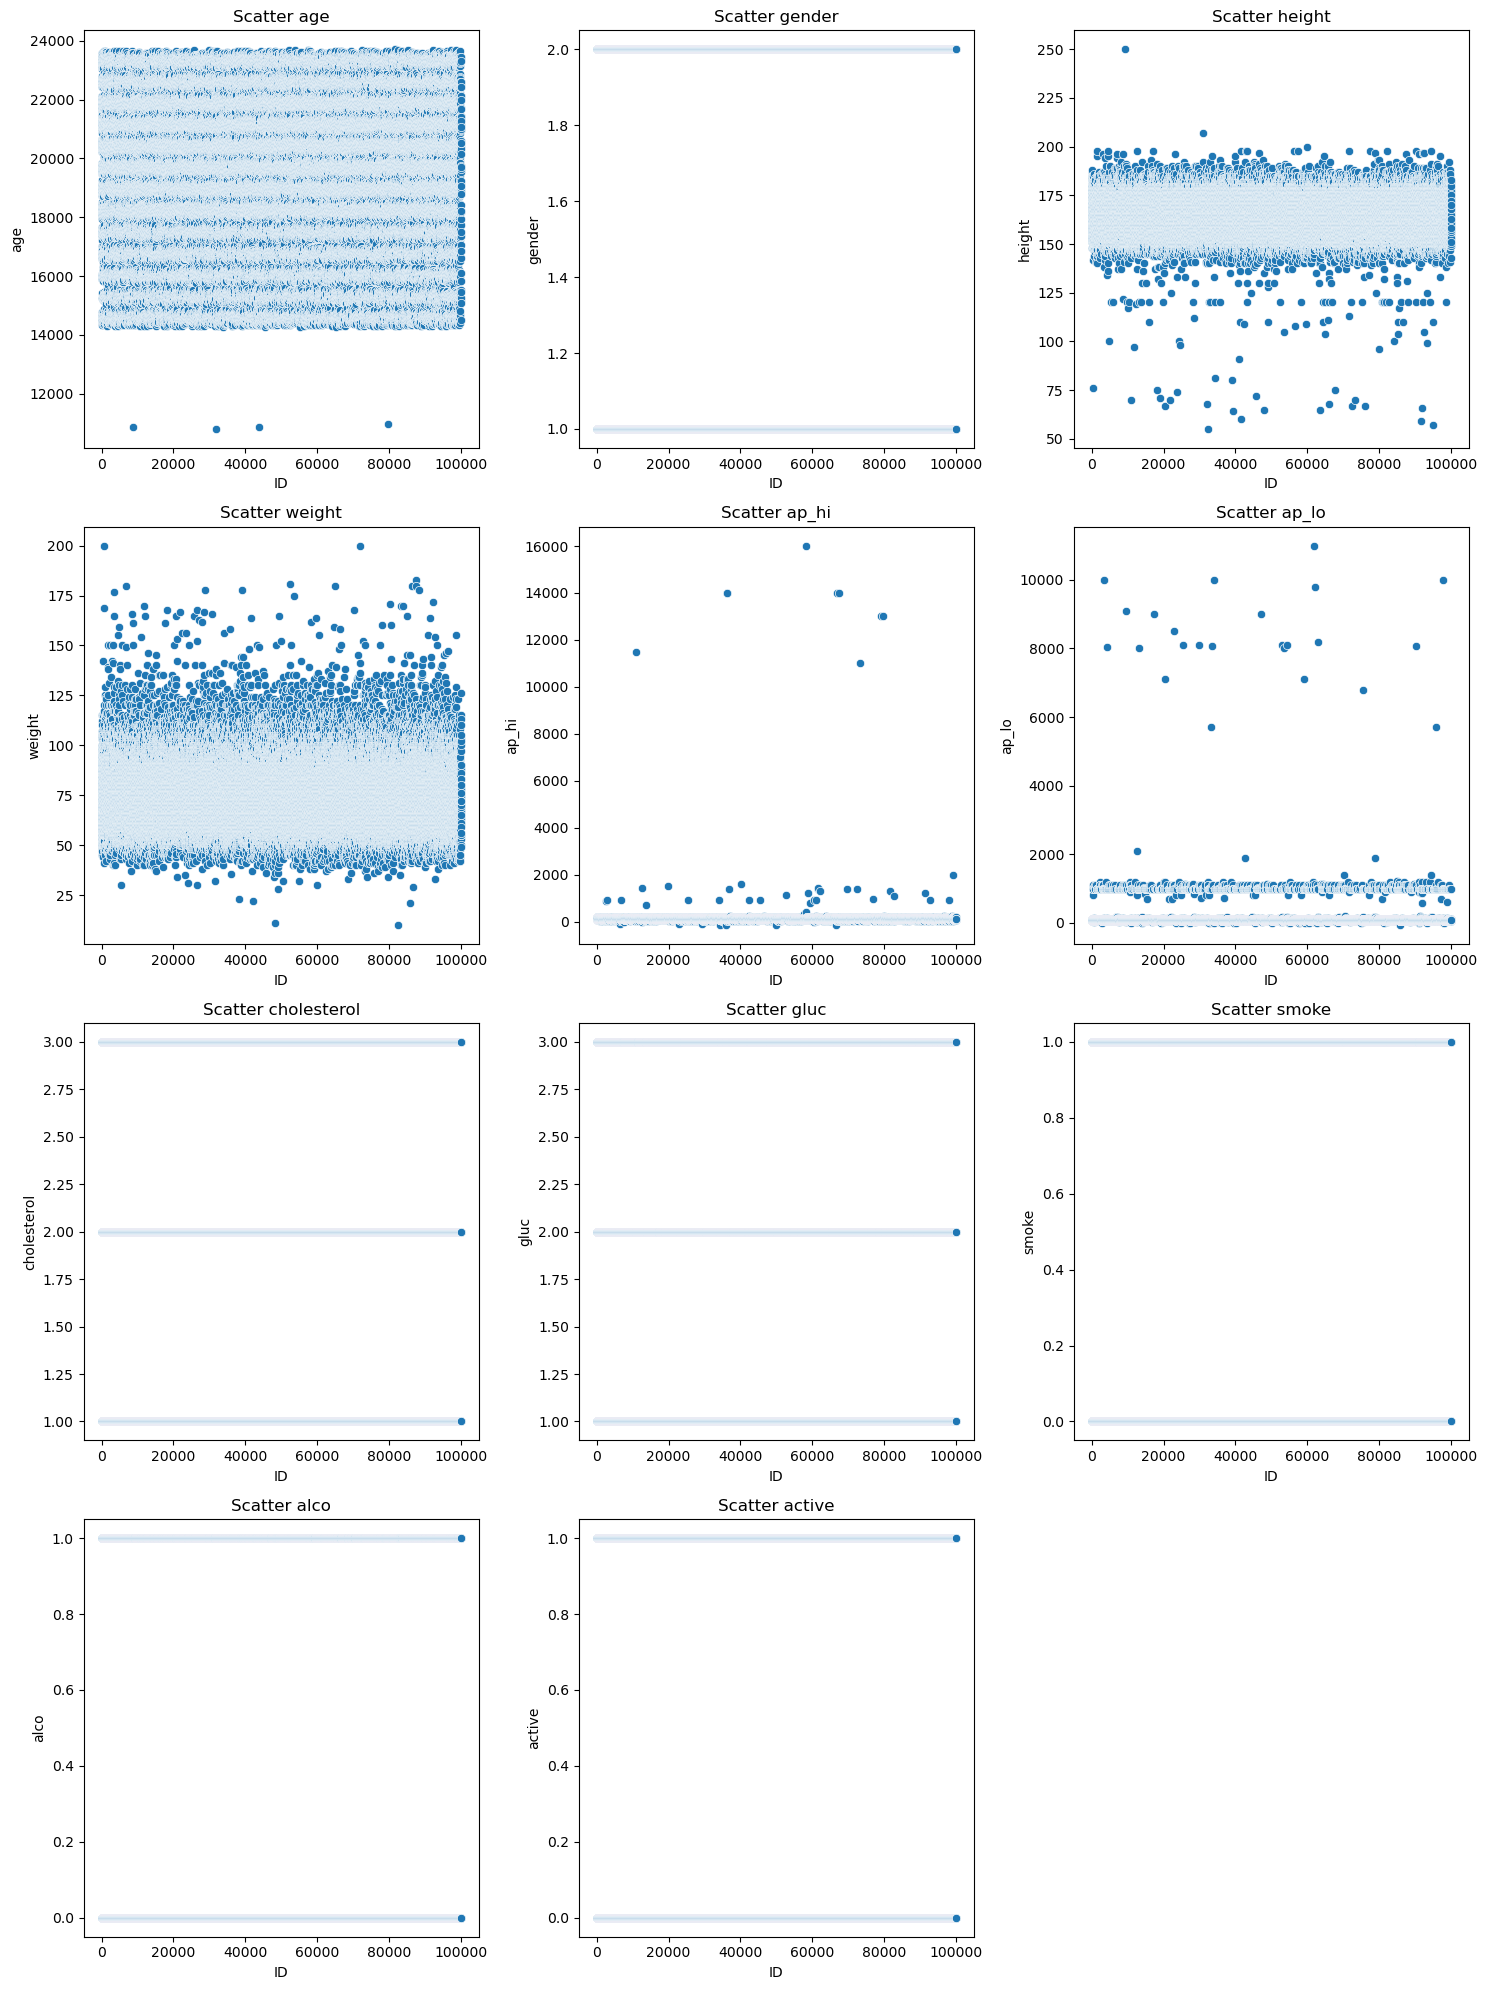

In [12]:
X_sense_ID = X.drop(columns=["id"])

n_cols = 3
n_rows = len(X_sense_ID.columns) // n_cols + (len(X_sense_ID.columns) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(X_sense_ID.columns):
    sns.scatterplot(x=X["id"], y=X[col], ax=axes[i])
    axes[i].set_title(f"Scatter {col}")
    axes[i].set_xlabel("ID")
    axes[i].set_ylabel(col)
    
for i in range(len(X_sense_ID.columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Podem observar que hi ha variables amb valors outliers, com "weight", "height" i "age", que s'escapen dels grups de valors on es concentra la resta de les dades:

-"Weight": Dades majorment concentrades entre 50 i 120 kg, amb valors que es desvien uniformement fins a 175 kg per sobre i fins a 25 kg per sota. Més enllà hi ha alguns pocs valors outliers, d'entre els quals destaquen dos de 200 kg.

-"Height": Dades majorment concentrades entre 150 i 180 cm. Veiem que hi ha diverses mostres per sota de 150 cm i un outlier prop de 250 cm. Aquest valor és gairebé impossible que sigui real i per tant l'haurem de treure durant el preprocessing.

-"Age": Dades majorment concentrades entre 14.000 i 24.000 dies (ja ho hem vist abans), alguns valors outliers per sota (prop dels 10.000 dies). De moment no els eliminarem, perquè ens poden servir perque el model aprengui de pacients més joves, tot i que potser podrien provocar overfitting (si finalment tenim overfitting, ja ens encarregarem de treure'ls).

També hi ha dos variables, "ap_hi" i "ap_lo", que tenen valors outliers extrems:


In [13]:
print("ap_hi:\n\n", X["ap_hi"].describe())
print("\n\nap_lo:\n\n", X["ap_lo"].describe())

ap_hi:

 count    70000.000000
mean       128.817286
std        154.011419
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64


ap_lo:

 count    70000.000000
mean        96.630414
std        188.472530
min        -70.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      11000.000000
Name: ap_lo, dtype: float64


Per a "ap_hi" veiem que el valor màxim (16020) és 125 vegades superior al valor de la mitjana (128), amb altres valors (que hem vist als scatters) també molt superiors als normals.

Per "ap_lo" veiem que el valor màxim (11000) és 114 vegades superior al valor de la mitjana (96), i també hem vist altres mostres amb valors massa elevats (per sobre de 6000).

També és important notar que hi ha fins i tot valors negatius, la qual cosa no té cap sentit biològic.

Tots aquests valors el hem d'interpretar com a errors de medició o relacionats amb problemes de codificació o processament de dades, ja que és impossible que cap persona pugui arribar a tenir aquests valors de pressió sanguínia, i no els podem deixar en el nostre dataset ja que podrien provocar overfitting.

Si ens fixem en l'scatter de la variable "ap_lo", veiem que hi ha molts valors concentrats al voltant dels 1.300 mmHg. Aquests valors també són impossibles d'assolir, però sembla que són molts valors, i si eliminimem masses valors el model podria no entrenar-se correctament. Anem a veure el nombre de mostres concentrades entorn als 1.300 mmHg:

In [14]:
print("\nNombre de mostres amb 'ap_lo' concentrades entorn als 1.300 mmHg:\n")
print(((X["ap_lo"] > 600) & (X["ap_lo"] < 1500)).sum())


Nombre de mostres amb 'ap_lo' concentrades entorn als 1.300 mmHg:

925


925 mostres són aproximadament el 1.3% del total de les dades (70.000 mostres), per tant, com que tampoc representen un alt porcentatge del nombre de mostres, i a més són mostres que contenen valors impossibles, ens podem permetre eliminar-los, sense afectar greument a l'entrenament del model.

Per evitar confondre al model amb valors fisiològicament impossibles (que cap èsser humà ha assolit ni es pensa que pugui assolir mai), definirem un intervals de valors acceptables per a les variables "ap_io", "ap_lo", "weight" i "height", que són les variables contínues del nostre dataset.

Aquests intervals tindràn en compte no només els valors sans, sinó també els insans (que són precísament els que ens interessen, per poder detectar si hi ha relacions o no entre aquestes variables i el target). El que no volem tenir en compte són els valors impossibles.

Els intervals, que agafen els valors "possibles" de les 4 variables abans nombrades i que a més, se'ls hi ha afegit una extensió de tolerància (per poder agafar també valors anòmals), són els següents (tenint present que l'edat mínima de la nostra base de dades és de 29 anys, ja que aquests intervals canviarien si els pacients fossin nens):


"weight" --> [30, 250] (de 10 a 250 kilograms)

"height" --> [55, 220] (de 5 a 220 centímetres)

"ap_lo" --> [8, 180] (de 8 a 180 mmHg)

"ap_hi" --> [40, 400] (de 40 a 400 mmHg)

Considerem que tots els valors fora dels intervals anteriors són impossibles (o gairebé impossibles) d'assolir i, per tant, no els tindrem en compte en la nostra base de dades (els eliminarem durant el preprocessing).

A la part de distribucions, només ens queda ara mostrar la distribució del target ("cardio"):

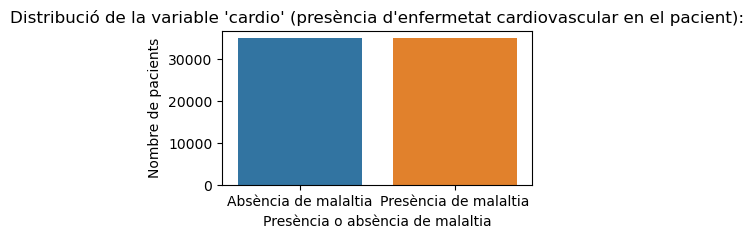

cardio
0    35021
1    34979
Name: count, dtype: int64
cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64


In [15]:
plt.figure(figsize=(4, 2))
sns.countplot(x=y, data=X)
plt.title("Distribució de la variable 'cardio' (presència d'enfermetat cardiovascular en el pacient):")
plt.xlabel('Presència o absència de malaltia')
plt.ylabel('Nombre de pacients')
plt.xticks(ticks=[0, 1], labels=['Absència de malaltia', 'Presència de malaltia'])
plt.show()

counts = y.value_counts()
print(counts)

proportions = y.value_counts(normalize=True)
print(proportions)

Podem observar que les dues classes tenen gairebé la mateixa distribució (estan balancejades), per tant, no ens caldrà realitzar cap mètode de balanceig al target.

Ara que ja hem parlat sobre les distribucions de les dades, anem a mostrar la matriu de correlacions, per veure quines dades estan o no correlacionades entre elles, i quina informació en podem treure:

<Axes: >

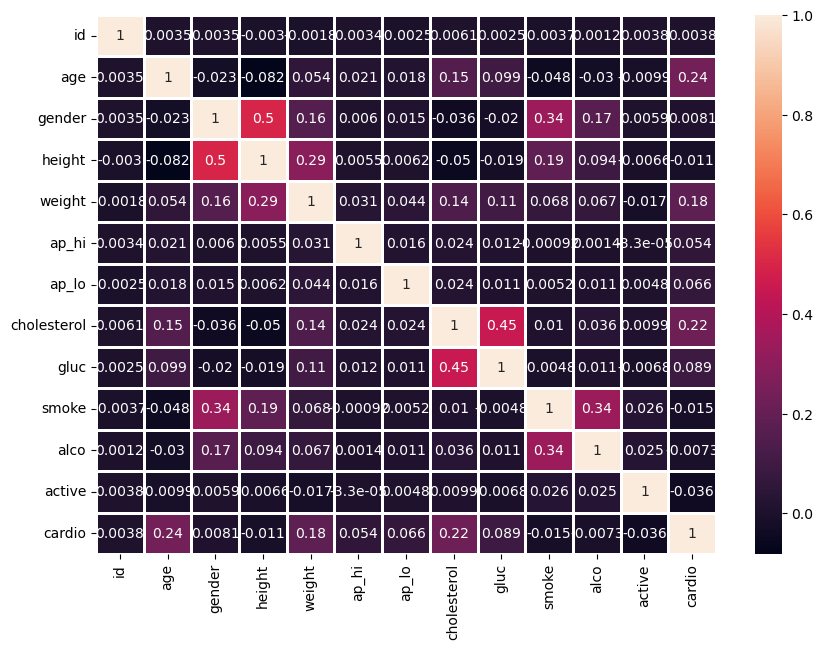

In [16]:
plt.figure(figsize=(10,7))
sns.heatmap(pd.concat([X,y],axis=1).corr(),annot=True,linewidths=2)

Donada la matriu de correlacions, podem observar les següentes correlacions entre features:

-"gender" i "height": Correlació positiva de 0.5, això vol dir que com més alt és "gender", més alt serà "height", i viceversa. Aquesta correlació té sentit, ja que, habitualment, els homes (codificats com a 2) són més alts que les dones (codificats com a 1). Podem conservar ambdues variables ja que la correlació no és extremadament alta i el model pot aprendre la relació.

-"gender" i "weight": Correlació positiva de 0.16, pel mateix motiu que em mencionat abans amb l'alçada.

-"height" i "weight": Correlació positiva de 0.29. Té sentit, ja que com més altes són les persones, més solen pesar. Podríem conservar ambdues variables, ja que la correlació no és alta i creiem que el pes té un efecte important a l'hora de parlar de malalties cardiovasculars (després ho veurem). Tot i això, una millor estratègia podria ser fusionar les dues variables en una, l'IMC (o índex de massa corporal, BMI en anglès), que és una mesura que relaciona el pes i l'alçada per estimar si té un pes saludable. Construir una variable IMC (i eliminar les variables "height" i "weight") pot ser beneficiós per diversos motius, però sobretot perquè suposa una reducció de la dimensionalitat (menys variables, per tant, un model que costarà menys entrenar), proporciona una relació més informativa (IMC és una mesura habitual de la salut de les persones, més que el pes o l'alçada per separats) i per simplificar el dataset. Llavors, el que farem amb aquestes dues variables, quan arribem a la fase de preprocessing, serà crear una nova columna "BMI" que les substitueixi.

-"gender" i "smoke": Correlació positiva de 0.34. Ens indica que els homes fumen més que les dones. Si més endavant veiem que una de les dos variables està correlacionada amb el target i l'altra no, podríem eliminar una de les dues, per simplificar el dataset i l'entrenament del model.

-"height" i "smoke": Correlació positiva de 0.19. Ens indica que com més pesa un pacient, més probabilitat té de fumar. A priori, aquesta relació no té gaire sentit (no hi ha cap raó que indiqui que fumar fa que una persona creixi, o que les persones altes fumin més).

-"gender" i "alco": Correlació positiva de 0.17. Ens indica que els homes tenen més probabilitat de veure més alcohol que les dones.

-"cholesterol" i "gluc": Correlació positiva de 0.45. Ens indica que com més colesterol té una persona, més glucosa té, i viceversa. Segons Més endavant veurem que ambdues variables estan relaciones amb el target. De moment ens quedarem amb les dues, però si el model presenta overfitting, podríem eliminar la variable "gluc" (per tener una menor correlació amb el target) o crear una variable combinada.

Ara veiem les relacions més importants entre features i target:

-"age" i "cardio": Correlació positiva de 0.24. Ens indica que les perones més grans tenen més probabilitat de tenir una enfermetat cardiovascular.

-"weight" i "cardio": Correlació positiva de 0.18. Ens indica que les persones amb més pes tenen més probabilitat de tenir una enfermetat cardiovascular.

-"cholesterol" i "cardio": Correlació positiva de 0.22. Ens indica que les persones amb més colesterol en sang tenen més probabilitat de tenir una enfermetat cardiovascular.

-"gluc" i "cardio": Correlació positiva  de 0.089. És inferior a la correlació que té el target amb "cholesterol", per tant, si el model amb les dades actuals presenta resultats pobres, podríem provar eliminant "gluc" (ja que "cholesterol" presenta informació semblant, llavors es simplificaria el model).

-"ap_hi" i "cardio": Correlació positiva de 0.054. És una relació petita, però no tant com altres variables.

-"ap_lo" i "cardio": Correlació positiva de 0.066. També es una relació petita, llavors si veiem que el model es torna molt complexe, podríem també provar d'eliminar les variables "ap_hi" i "ap_lo", per veure si millora.

-Variables subjectives ("alco", "smoke" i "active") i "cardio": Contràriament al que ens podríem pensar en un inici, aquestes variables tenen una correlació ínfima (i en el cas de "alco" i "active", la relació és fins i tot inversa) amb tenir o no enfermetats cardiovasculars. Gràcies als coneixements mèdics [1][2] que tenim en l'actualitat, sabem que l'alcohol, el tabac i el sedentarisme són estils de vida que poden conduir més fàcilment a contraure una enfermetat cardiovascular, llavors podem pensar que les nostres dades podrien no ser correctes, o bé perquè el pacient ha mentit a l'hora de contestar sobre els seus estils de vida, o bé perquè hi ha hagut errors de transcripció a les dades, o simplement perquè hi ha hagut la casualitat que les mostres recollides en aquesta base de dades no són com les d'altres datasets amb els que s'han fet els experiments que han demostrat que l'alcohol, el tabac i la falta d'activitat física estan molt correlacionats positivament amb la contracció de malalties cardiovasculars. Per estar segurs del que ens diu la matriu de correlacions, anem a mostrar ara les agrupacions de les variables subjectives amb el target.

In [17]:
print(pd.concat([X,y],axis=1)[["smoke","cardio"]].groupby(["smoke"], as_index = False).mean().sort_values(by="cardio"))
X['smoke'].value_counts()[1]

   smoke    cardio
1      1  0.474793
0      0  0.502107


6169

In [18]:
print(pd.concat([X,y],axis=1)[["alco","cardio"]].groupby(["alco"], as_index = False).mean().sort_values(by="cardio"))
X['alco'].value_counts()[1]

   alco    cardio
1     1  0.484325
0     0  0.500574


3764

In [19]:
print(pd.concat([X,y],axis=1)[["active","cardio"]].groupby(["active"], as_index = False).mean().sort_values(by="cardio"))
X["active"].value_counts()[0]

   active    cardio
1       1  0.490891
0       0  0.535774


13739

Veiem que, com ja ens deia la matriu de correlacions, en el nostre dataset, els pacients que fumen o beuen alcohol tenen menys probabilitat de tenir una enfermetat cardiovascular que els pacients que no fumen o no beuen. D'altra banda, fer activitat física presenta menys probabilitats de tenir una enfermetat cardiovascular que no fer activitat física, però la diferència és d'un 4%, i en un principi pensàvem que seria més gran.

El que farem serà conservar les dades subjectives, i si veiem que el model presenta uns resultats pobres, probarem el model sense les variables subjectives, per veure si millora o no.

Finalment, per acabar amb la part d'EDA, i abans de començar el Preprocessing, farem la divisió entre les dades d'entrenament i les de prova. Les dades d'entrenament les utilitzarem per entrenar els diversos models que construirem, i també per validar-los. D'altra banda, el conjunt de test quedarà aillat fins que haguem acabat la validació, i haguem seleccionat el millor model, i l'utilitzarem només per obtenir un recall -i altres mètriques- final que avaluin definitivament el nostre treball.

Reservarem, com és usual, un 20% del total de dades per al conjunt de test, i farem l'split de manera que les classes, en cada subconjunt, quedin balancejades (amb l'opció stratify=y).

També farem còpies dels datasets abans de tractar-los, per tenir accès a les dades originals en cas que les necessitem.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_original = X_train.copy(deep=True)
X_test_original = X_test.copy(deep=True)
y_train_original = y_train.copy(deep=True)
y_test_original = y_test.copy(deep=True)

També és important mencionar que, durant la fase de preprocessing, haurem d'eliminar la columna "id", ja que només s'utilitza per indexar les dades i no té cap relació (com també es pot veure a la matriu de correlacions) amb el target.

## 2. Preprocessing

Aplicarem els tractaments que hem anat mencionant durant l'EDA. En cas que haguem de fer tractaments tant en el conjunt de train com en el de test, es faran per separats, per evitar data leakage.

1. Passar els valors de la variable "age" a anys (en comptes de mantenir els valors en dies), per guanyar interpretació i evitar problemes d'escala.

In [21]:
print(X_train["age"].head(), "\n")

X_train["age"] = X_train["age"] / 365.25
X_test["age"] = X_test["age"] / 365.25

print("\n", X_train["age"].head())

58394    18995
60371    17319
41399    19017
11468    20388
20650    18236
Name: age, dtype: int64 


 58394    52.005476
60371    47.416838
41399    52.065708
11468    55.819302
20650    49.927447
Name: age, dtype: float64


2. Eliminar valors de les variables discretes "weight", "height", "ap_lo" i "ap_hi" que estiguin fora dels intervals establerts durant l'EDA, ja que no són valors reals. Si es tractés d'outliers normals, s'eliminaríen només en el dataset d'entrenament, però no es tracta de valors outliers, sinó de valors impossibles (com hem vist abans, per exemple, que hi havia pacients amb una pressió sanguínea negativa). Per tant, els hem d'eliminar tant del conjunt d'entrenament com del conjunt de prova.

    "weight" --> [30, 250] (de 10 a 250 kilograms)

    "height" --> [55, 220] (de 5 a 220 centímetres)

    "ap_lo" --> [8, 180] (de 8 a 180 mmHg)

    "ap_hi" --> [40, 400] (de 40 a 400 mmHg)

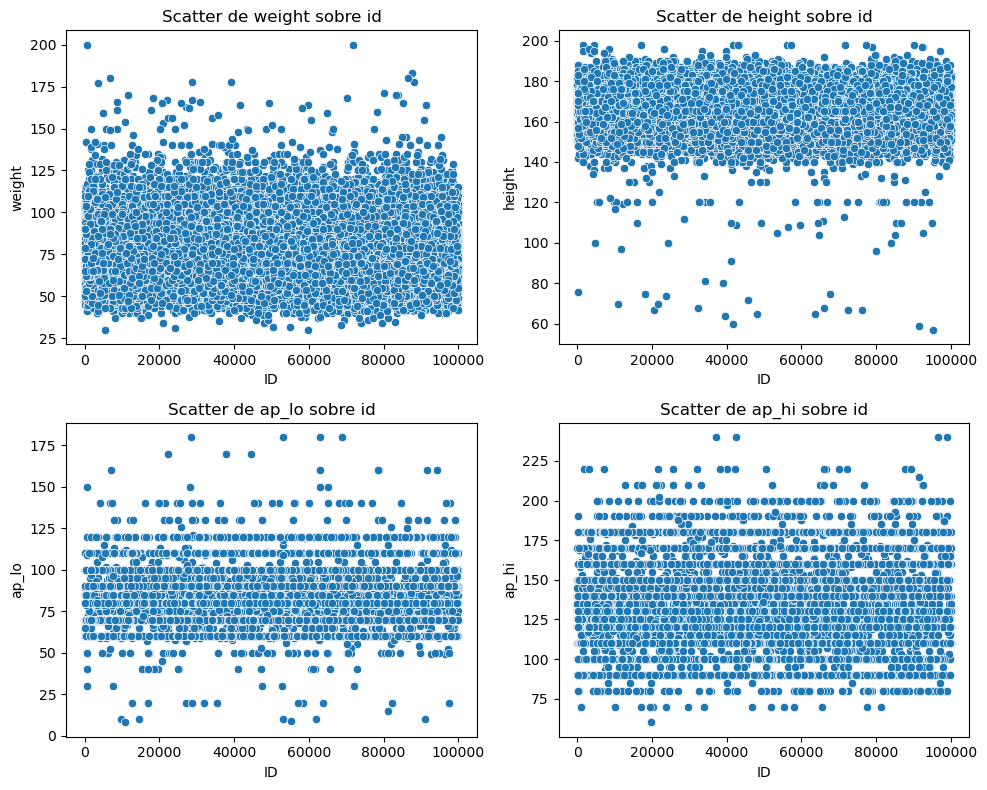

0 0

Número de mostres eliminades per contenir valors irreals:

Train:  965
Test:  240


In [22]:
columnes = ['weight', 'height', 'ap_lo', 'ap_hi']
intervals = [(30, 250), (55, 220), (8, 180), (40, 400)]

for columna, interval in zip(columnes, intervals):
    mask_train = (X_train[columna] >= interval[0]) & (X_train[columna] <= interval[1])
    mask_test = (X_test[columna] >= interval[0]) & (X_test[columna] <= interval[1])
    
    # APLIQUEM MÀSCARES PER CONSERVAR NOMÉS ELS VALORS VÀLIDS
    X_train = X_train[mask_train]
    y_train = y_train[mask_train]
    
    X_test = X_test[mask_test]
    y_test = y_test[mask_test] 
    
# MOSTREM LES NOVES DISTRIBUCIONS, PER VEURE SI HEM ELIMINAT ELS VALORS IRREALS

n_cols = 2
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 8))
axes = axes.flatten()
for i, columna in enumerate(columnes):
    sns.scatterplot(x=X_train['id'], y=X_train[columna], ax=axes[i])
    axes[i].set_title(f'Scatter de {columna} sobre id')
    axes[i].set_xlabel('ID')
    axes[i].set_ylabel(columna)
plt.tight_layout()
plt.show()

print(X_train.isna().sum().sum(), X_test.isna().sum().sum())
print("\nNúmero de mostres eliminades per contenir valors irreals:\n")
print("Train: ", X_train_original.shape[0]-X_train.shape[0])
print("Test: ", X_test_original.shape[0]-X_test.shape[0])

Com podem observar, ja no existeixen valors irreals (o almenys hem eliminat la major part), però ara el que tenim són valors extrems (outliers que sí que poden ser reals). Com que el número de valors "normals" és molt més gran que el número d'outliers, de moment no cal que ens preocupem per aquests outliers, però si el rendiment del model no acaba de ser del tot bò, podem provar a eliminar-los.

3. Crear una columna "BMI" (índex de massa corporal) a partir de les variables "weight" y "height".

In [23]:
# FÒRMULA IMC: pes / alçada^2. Pes en kg i alçada en m

X_train['BMI'] = X_train['weight'] / (X_train['height'] / 100) ** 2
X_test['BMI'] = X_test['weight'] / (X_test['height'] / 100) ** 2

print(X_train.head())

          id        age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
58394  83327  52.005476       2     162    83.0    120     80            1   
60371  86196  47.416838       1     158    64.0    120     80            1   
41399  59158  52.065708       1     165    95.0    160    100            2   
11468  16399  55.819302       1     164    83.0    150    100            1   
20650  29470  49.927447       1     156    52.0    100     67            1   

       gluc  smoke  alco  active        BMI  
58394     1      0     0       0  31.626276  
60371     1      0     0       1  25.636917  
41399     1      0     0       1  34.894399  
11468     1      0     0       1  30.859607  
20650     1      0     0       0  21.367521  


4. Eliminar les columnes 'weight' i 'height' per disminuir la dimensionalitat (ja estan representades per la columna 'BMI').

In [24]:
X_train = X_train.drop(columns=['weight', 'height'])
X_test = X_test.drop(columns=['weight', 'height'])

print(X_train.head())

          id        age  gender  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
58394  83327  52.005476       2    120     80            1     1      0     0   
60371  86196  47.416838       1    120     80            1     1      0     0   
41399  59158  52.065708       1    160    100            2     1      0     0   
11468  16399  55.819302       1    150    100            1     1      0     0   
20650  29470  49.927447       1    100     67            1     1      0     0   

       active        BMI  
58394       0  31.626276  
60371       1  25.636917  
41399       1  34.894399  
11468       1  30.859607  
20650       0  21.367521  


5. Afegir mostres de les classes "2" i "3" a la variable "cholesterol" per tal de balancejar-la. Abans hem vist que la classe "1" (colesterol baix) representava més del 70% del total de les mostres, i això pot afectar negativament al rendiment del model. Realitzarem oversampling simple (duplicació de valors seleccionats aleatòriament) per equilibrar la variable. No podem utilitzar SMOTE perquè és un mètode que està dissenyat específicament per al target, no per als features.

Hem de tenir en compte, però, que el fet de realitzar oversampling fins equilibrar completament totes les classes pot tenir efectes col·laterals negatius en el nostre dataset, com per exemple un creixement desmesurat del nombre de mostres, una pèrdua de fiabilitat de la validació creuada (hi hauran mostres repetides que es podran veure tant en el conjunt d'entrenament com en el de validació) o també pot passar que desequilibrem les variables que ja estàven equilibrades. Per tant, no farem oversampling fins equilibrar totes les classes, sinó que buscarem un valor raonable donat el nombre de mostres de les classes disponibles per aconseguir un equilibri parcial. També ho combinarem amb undersampling en la classe majoritària, que consisteix en reduir el nombre de mostres de la classe majoritària.

L'estratègia que utilitzarem, basada en les proporcions de la classe "cholesterol" que [hem vist durant l'EDA](#DISTRIBUCIONS:) (aproximadament un 75% de la classe 1 i un 12.5% de les altres classes) serà disminuir en un 5% el nombre de mostres de la classe 1 i augmentar un 80% el nombre de mostres de les classes 2 i 3.

L'objectiu és equilibrar parcialment les classes, però sense perdre informació important de la classe majoritària eliminant molts valors ni tampoc produir overfitting generant moltes rèpliques exactes de les mostres existents, per tant, seguirem una estratègia conservadora.

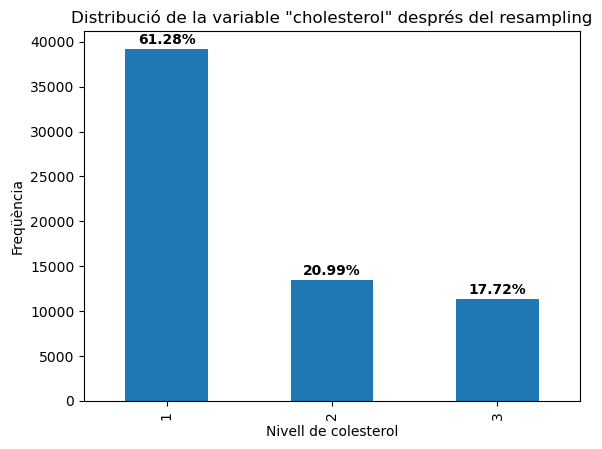

                 id           age        gender         ap_hi         ap_lo  \
count  63980.000000  63980.000000  63980.000000  63980.000000  63980.000000   
mean   50083.462394     53.569375      1.340794    127.612676     81.791497   
std    28824.610517      6.693191      0.473980     17.148510      9.854678   
min        0.000000     29.730322      1.000000     60.000000      8.000000   
25%    25175.000000     49.390828      1.000000    120.000000     80.000000   
50%    50288.000000     54.095825      1.000000    120.000000     80.000000   
75%    74890.250000     58.814511      2.000000    140.000000     90.000000   
max    99999.000000     64.865161      2.000000    240.000000    180.000000   

        cholesterol          gluc         smoke          alco        active  \
count  63980.000000  63980.000000  63980.000000  63980.000000  63980.000000   
mean       1.564411      1.295374      0.088512      0.055642      0.804845   
std        0.774820      0.642148      0.284040    

In [25]:
# SEPAREM LES CLASSES MAJORITÀRIES I MINORITÀRIES (HO FEM TANT EN X_train COM EN y_train, ES SELECCIONARAN LES MATEIXES MOSTRES EN FEATURE I EN TARGET)

major_class_1 = X_train[X_train['cholesterol'] == 1]
minor_class_2 = X_train[X_train['cholesterol'] == 2]
minor_class_3 = X_train[X_train['cholesterol'] == 3]

y_train_class_1 = y_train[X_train['cholesterol'] == 1]
y_train_class_2 = y_train[X_train['cholesterol'] == 2]
y_train_class_3 = y_train[X_train['cholesterol'] == 3]


# UNDERSAMPLING DE LA CLASSE MAJORITÀRIA

sampling_target = int(len(major_class_1)*0.95)

major_class_1_undersampled = resample(major_class_1,
                                      replace=False,
                                      n_samples=sampling_target,
                                      random_state=42)
y_train_major_class_1_undersampled = resample(y_train_class_1,
                                              replace=False,
                                              n_samples=sampling_target,
                                              random_state=42)

# OVERSAMPLING DE LES CLASSES MINORITÀRIES

sampling_target = int(len(minor_class_2)*1.8)

minor_class_2_oversampled = resample(minor_class_2,
                                     replace=True,
                                     n_samples=sampling_target,
                                     random_state=42)
y_train_minor_class_2_oversampled = resample(y_train_class_2,
                                             replace=True,
                                             n_samples=sampling_target,
                                             random_state=42)

sampling_target = int(len(minor_class_3)*1.8)

minor_class_3_oversampled = resample(minor_class_3,
                                     replace=True,
                                     n_samples=sampling_target,
                                     random_state=42)
y_train_minor_class_3_oversampled = resample(y_train_class_3,
                                             replace=True,
                                             n_samples=sampling_target,
                                             random_state=42)

# COMBINAR TOTES LES CLASSES
X_train = pd.concat([major_class_1_undersampled, minor_class_2_oversampled, minor_class_3_oversampled]).reset_index(drop=True)
y_train = pd.concat([y_train_major_class_1_undersampled, y_train_minor_class_2_oversampled, y_train_minor_class_3_oversampled]).reset_index(drop=True)

# OBSERVEM ELS RESULTATS DEL RESAMPLING
ax = X_train['cholesterol'].value_counts().plot(kind='bar')
plt.title('Distribució de la variable "cholesterol" després del resampling')
plt.xlabel('Nivell de colesterol')
plt.ylabel('Freqüència')
total = X_train['cholesterol'].value_counts().sum()
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%',
                (p.get_x() + p.get_width() / 2, height+1000),
                ha='center', va='center', fontsize=10, color='black', fontweight='bold')
plt.show()

print(X_train.describe(), "\n")
print(y_train.describe(), "\n")

print(pd.crosstab(X_train['cholesterol'], y_train, normalize='index'), "\n")

Observem que ara les tres classes estan més balancejades que abans (abans la classe 1 representava el 75% de les mostres, i ara ho fa un 61%, mentre que les altres variables tenien un 12% i ara entorn al 20%) i la relació de cada classe amb el target continua éssent igual que abans, per tant, el resampling s'ha realitzat correctament.

6. Repetim el procés, però ara amb la variable "gluc": afegir mostres de les classes "2" i "3" a la variable "gluc" per tal de balancejar-la, i eliminar algunes mostres de la classe 1 (undersampling). Abans hem vist que la classe "1" (nivells baixos de glucosa) representava més del 80% del total de les mostres, i això pot afectar negativament al rendiment del model. 

El que farem en el cas de la glucosa serà eliminar un 10% de la classe 1 (la majoritària) i augmentar en un 90% el número de mostres de les classes 2 i 3.

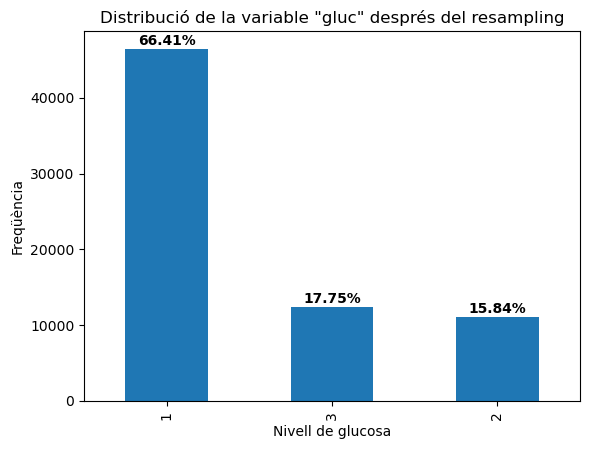

                 id           age        gender         ap_hi         ap_lo  \
count  69945.000000  69945.000000  69945.000000  69945.000000  69945.000000   
mean   50151.180427     53.768832      1.335535    128.279105     82.090585   
std    28861.100596      6.663741      0.472181     17.533940      9.959006   
min        0.000000     29.730322      1.000000     60.000000      8.000000   
25%    25126.000000     49.590691      1.000000    120.000000     80.000000   
50%    50491.000000     54.234086      1.000000    120.000000     80.000000   
75%    74999.000000     59.373032      2.000000    140.000000     90.000000   
max    99999.000000     64.843258      2.000000    240.000000    180.000000   

        cholesterol          gluc         smoke          alco        active  \
count  69945.000000  69945.000000  69945.000000  69945.000000  69945.000000   
mean       1.684180      1.513318      0.086396      0.056116      0.803131   
std        0.818248      0.777649      0.280951    

In [26]:
# SEPAREM LES CLASSES MAJORITÀRIES I MINORITÀRIES (HO FEM TANT EN X_train COM EN y_train, ES SELECCIONARAN LES MATEIXES MOSTRES EN FEATURE I EN TARGET)

major_class_1 = X_train[X_train['gluc'] == 1]
minor_class_2 = X_train[X_train['gluc'] == 2]
minor_class_3 = X_train[X_train['gluc'] == 3]

y_train_class_1 = y_train[X_train['gluc'] == 1]
y_train_class_2 = y_train[X_train['gluc'] == 2]
y_train_class_3 = y_train[X_train['gluc'] == 3]


# UNDERSAMPLING DE LA CLASSE MAJORITÀRIA

sampling_target = int(len(major_class_1)*0.9)

major_class_1_undersampled = resample(major_class_1,
                                      replace=False,
                                      n_samples=sampling_target,
                                      random_state=42)
y_train_major_class_1_undersampled = resample(y_train_class_1,
                                              replace=False,
                                              n_samples=sampling_target,
                                              random_state=42)

# OVERSAMPLING DE LES CLASSES MINORITÀRIES

sampling_target = int(len(minor_class_2)*1.9)

minor_class_2_oversampled = resample(minor_class_2,
                                     replace=True,
                                     n_samples=sampling_target,
                                     random_state=42)
y_train_minor_class_2_oversampled = resample(y_train_class_2,
                                             replace=True,
                                             n_samples=sampling_target,
                                             random_state=42)

sampling_target = int(len(minor_class_3)*1.9)

minor_class_3_oversampled = resample(minor_class_3,
                                     replace=True,
                                     n_samples=sampling_target,
                                     random_state=42)
y_train_minor_class_3_oversampled = resample(y_train_class_3,
                                             replace=True,
                                             n_samples=sampling_target,
                                             random_state=42)

# COMBINAR TOTES LES CLASSES
X_train = pd.concat([major_class_1_undersampled, minor_class_2_oversampled, minor_class_3_oversampled]).reset_index(drop=True)
y_train = pd.concat([y_train_major_class_1_undersampled, y_train_minor_class_2_oversampled, y_train_minor_class_3_oversampled]).reset_index(drop=True)

# OBSERVEM ELS RESULTATS DEL RESAMPLING
ax = X_train['gluc'].value_counts().plot(kind='bar')
plt.title('Distribució de la variable "gluc" després del resampling')
plt.xlabel('Nivell de glucosa')
plt.ylabel('Freqüència')
total = X_train['gluc'].value_counts().sum()
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%',
                (p.get_x() + p.get_width() / 2, height+1000),
                ha='center', va='center', fontsize=10, color='black', fontweight='bold')
plt.show()

print(X_train.describe(), "\n")
print(y_train.describe(), "\n")

print(pd.crosstab(X_train['gluc'], y_train, normalize='index'), "\n")

Tal i com ha passat amb la variable "cholesterol", les tres classes de "gluc" ara estan més balancejades (recordem que, abans del resampling, la classe 1 representava més del 80% de les mostres, i ara aquest percentatge ha baixat al 66%) i la relació de cada classe amb el target continua éssent igual, per tant, el resampling s'ha realitzat correctament.

No cal que balancegem les altres variables categòriques com "smoke", "alco" i "active" perquè hem vist que són variables amb un efecte baix en el target.

És important notar que el número de mostres s'ha mantingut gairebé igual, conservem una mica menys de 70.000 mostres (però hem perdut mostres úniques, substituint-les per mostres que són rèpliques).

El resampling, tot i que ha sigut bastant conservador i ens ha balancejat unes variables importants que afectaven al target, pot haver desbalancejat les altres variables. Anem a fer una visualització ràpida de les distribucions de tot el dataset, per assegurar-nos que el balanceig de les altres variables no s'ha vist afectat.

Començarem revisant el target ("cardio"):

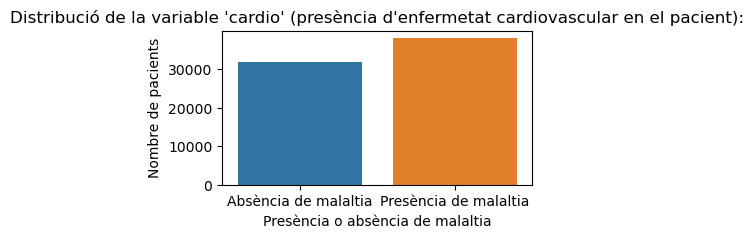

cardio
1    38055
0    31890
Name: count, dtype: int64
cardio
1    0.54407
0    0.45593
Name: proportion, dtype: float64


In [27]:
plt.figure(figsize=(4, 2))
sns.countplot(x=y_train, data=X_train)
plt.title("Distribució de la variable 'cardio' (presència d'enfermetat cardiovascular en el pacient):")
plt.xlabel('Presència o absència de malaltia')
plt.ylabel('Nombre de pacients')
plt.xticks(ticks=[0, 1], labels=['Absència de malaltia', 'Presència de malaltia'])
plt.show()

counts = y_train.value_counts()
print(counts)

proportions = y_train.value_counts(normalize=True)
print(proportions)

Veiem que el target s'ha desbalancejat lleugerament. Abans les classes estàven gairebé completament equilibrades, i ara hi ha una diferència del 10% entre elles. 

Per arreglar-ho, com es tracta del target, ara sí que podem utilitzar SMOTE (tècnica per crear mostres sintètiques a partir de les existents).

In [28]:
smote = SMOTE(random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)

print("Distribució del target després d'aplicar SMOTE:")
print(y_train.value_counts())

Distribució del target després d'aplicar SMOTE:
cardio
0    38055
1    38055
Name: count, dtype: int64


Ara ja tornen a estar equilibrades.

Continuem revisant les distribucions dels features:

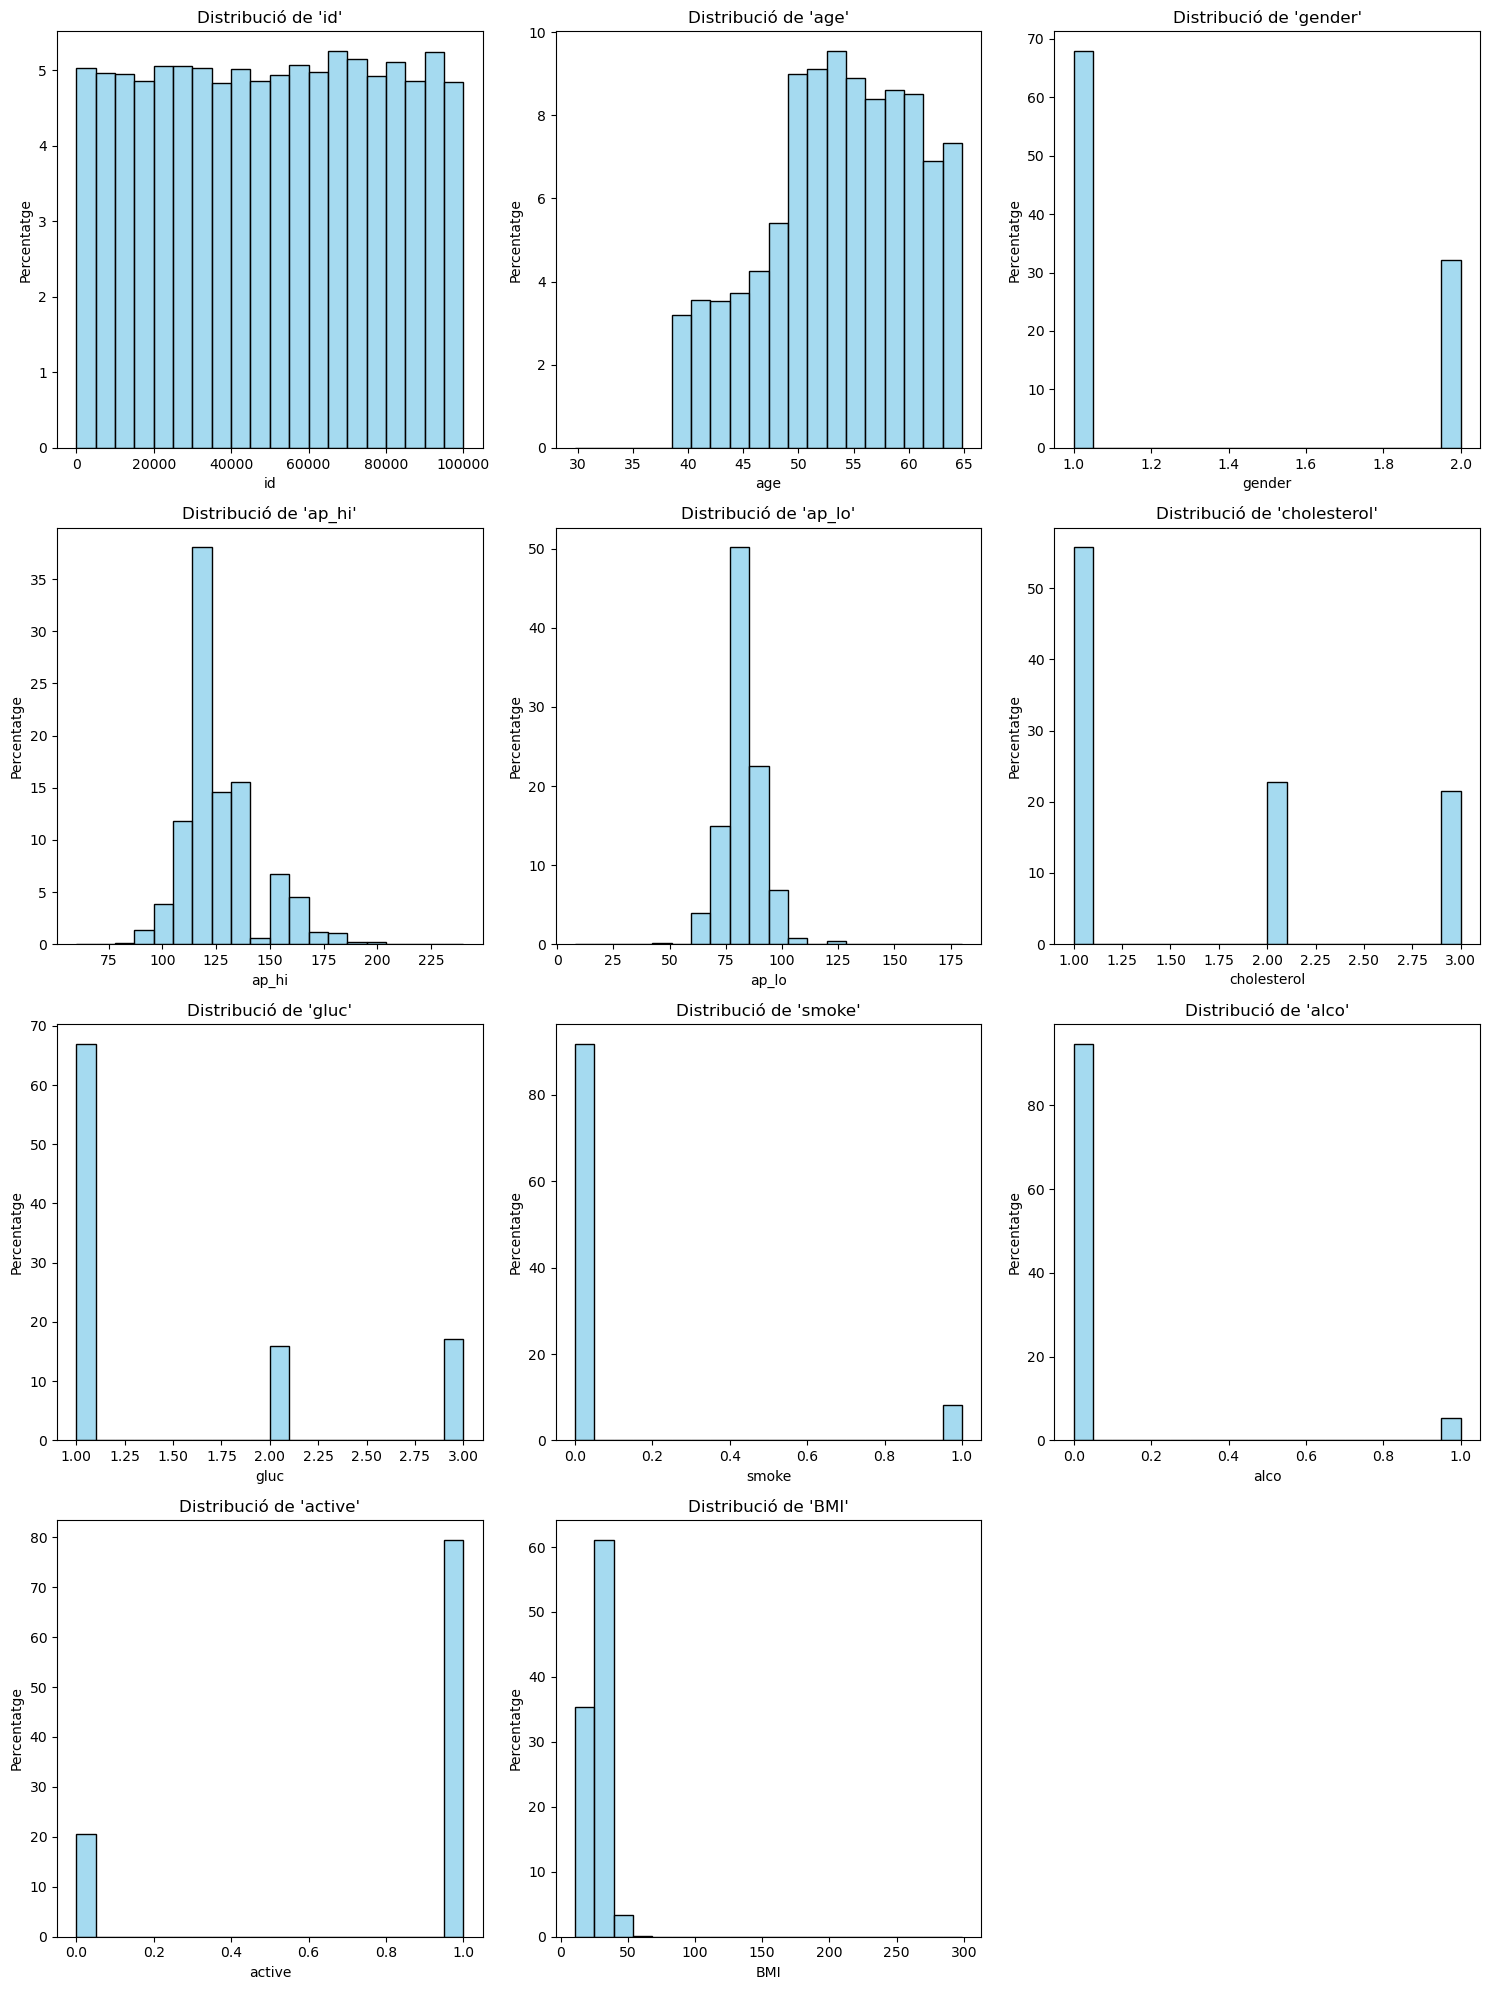

In [29]:
n_cols = 3
n_rows = len(X_train.columns) // n_cols + (len(X_train.columns) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, column in enumerate(X_train.columns):
    sns.histplot(X_train[column], kde=False, bins=20, stat="percent", color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f"Distribució de '{column}'")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Percentatge")

for i in range(len(X_train.columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Podem observar que les distribucions dels features continuen com havíem vist durant l'EDA, excepte les de les variables "cholesterol" i "gluc", que són les que hem equilibrat parcialment.

Per tant, tot correcte.

7. Estandaritzar les variables "BMI", "ap_lo" i "ap_hi". Com hem anat veient al llarg d'aquest informe, aquestes variables són numèriques continues, i per tant és important estandaritzar-les per facilitar l'entrenament dels models. Les dues opcions per estandaritzar més comunes són l'Standard Scaler i el Robust Scaler, el Robust Scaler és el més recomenat quan les variables que s'han d'estandaritzar tenen valors atípics. Com ja hem mencionat abans, i com podem veure també a continuació, les tres variables que volem estandaritzar tenen valors outliers:

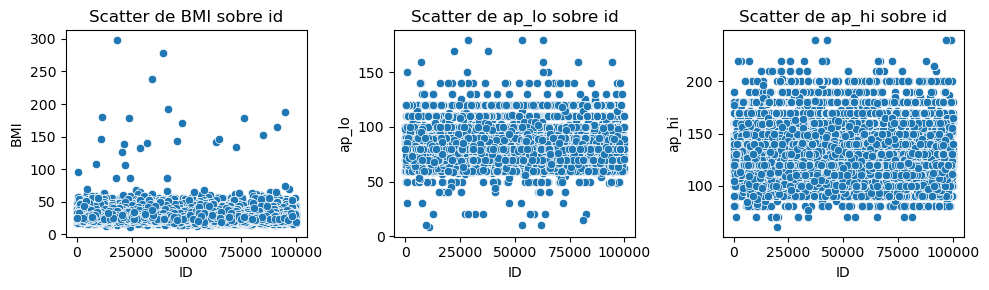

In [30]:
n_cols = 3
n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3))
axes = axes.flatten()
columnes = ["BMI", "ap_lo", "ap_hi"]
for i, columna in enumerate(columnes):
    sns.scatterplot(x=X_train['id'], y=X_train[columna], ax=axes[i])
    axes[i].set_title(f'Scatter de {columna} sobre id')
    axes[i].set_xlabel('ID')
    axes[i].set_ylabel(columna)
plt.tight_layout()
plt.show()

Podem observar que totes tres variables tenen valors outliers, per tant, utilitzarem el Robust Scaler, ja que aquest estandaritzador normalitza mitjançant la mediana i el rang interquartil (IQR), que són menys sensibles als outliers. La mediana no es veu alterada pels valors atípics i el rang interquartil és una mesura de dispersió que depèn de les posicions de la dada central i dels quartils, no dels valors extrems, com sí que passa en el Standar Scaler, que normalitza mitjançant la mitjana i desviació estàndard.

In [31]:
features_to_scale = ['BMI', 'ap_lo', 'ap_hi']

scaler = RobustScaler()

# IMPORTANT: Per evitar Data Leaking, ajustem l'scaler (fem fit) només amb les dades d'entrenament (fem fit i transform)

X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

# IMPORTANT: No ajustem l'scaler amb les dades de prova, només apliquem la normalització (fem transform però no fit)

X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

# Observem les dades d'entrenament després d'aplicar la normalització

print(X_train.describe())

                 id           age        gender         ap_hi         ap_lo  \
count  76110.000000  76110.000000  76110.000000  76110.000000  76110.000000   
mean   50138.096597     53.656302      1.321246      0.381281      0.180911   
std    28861.010589      6.620097      0.466958      0.863466      0.982036   
min        0.000000     29.730322      1.000000     -3.000000     -7.200000   
25%    25145.500000     49.503080      1.000000      0.000000      0.000000   
50%    50435.000000     54.162902      1.000000      0.000000      0.000000   
75%    74962.750000     58.751540      2.000000      1.000000      1.000000   
max    99999.000000     64.843258      2.000000      6.000000     10.000000   

        cholesterol          gluc         smoke          alco        active  \
count  76110.000000  76110.000000  76110.000000  76110.000000  76110.000000   
mean       1.658205      1.501564      0.081422      0.052858      0.794298   
std        0.809979      0.769729      0.273483    

8. Escalar la columna "age". Tot i que per alguns models com el "Random Forest" no seria necessari escalar-la, ja que divideix les dades amb base en rangs, i tot i que els seus valors estan concentrats en un rang bastant concret (ho hem vist a l'EDA), per alguns models que són sensibles a l'escala (SVM, Regressor Logístic, etc) seria recomanable escalar-la per tant que aquesta variable no domini sobre altres variables amb rangs més petits. Com que no és una columna amb molts outliers, podem utilitzar un Standard Scaler en comptes d'un Robust Scaler.


In [32]:
scaler = StandardScaler()

X_train['age'] = scaler.fit_transform(X_train[["age"]])

X_test["age"] = scaler.transform(X_test[["age"]])

9. Per finalitzar amb el Preprocessing, eliminem la columna "id". Aquesta columna la feiem servir per mostrar els scatters i altra informació gràfica, però no té cap relació amb si el pacient tindrà o no una enfermetat cardiovascular i per tant ens molesta ja que pot confondre als models.

In [33]:
X_train = X_train.drop('id', axis=1)
X_test = X_test.drop('id', axis=1)

## 3. Metrics

En aquest apartat explicarem per què s'utilitzarà la mètrica **Recall** com a mètrica principal (també ho hem dit al començament de l'informe) i definirem funcions que ens ajudaran a interpretar els resultats que ens donin els models que entrenarem en el següent apartat.

Com ja hem mencionat durant l'EDA, ens interessa utilitzar el **Recall** com a mètrica principal perque la nostra màxima prioritat és identificar la màxima quantitat de persones amb malalties cardiovasculars (positius), ja que aquestes són les que necessiten una intervenció mèdica. Si utilitzéssim altres mètriques com accuracy o precision, podríem perdre molts casos importants (falsos negatius), la qual cosa seria perillós en un context de salut, ja que significa que no estem detectant correctament a aquells pacients que realment tenen la malaltia (i per tant, no els podrem tractar). El recall ajuda a minimitzar aquest risc, maximitzant la detecció dels casos positius. Sí que és veritat, però, que amb el Recall potser ens trobem amb més pacients diagnosticats de malaties cardiovasculars quan realment són sans (falsos positius), però hem de tenir en compte que en un context mèdic real, quan es diagnostica com a positiu un pacient, abans de començar el tractament se li realitzen més proves per estar completament segurs del diagnòstic inicial.

D'altra banda, quan utilitzem el Recall com a mètrica principal sorgeix un problema important: un model que classifiqués totes les mostres com a positives tindria un recall del 100%, encara que fos un model inútil. Per aquest motiu, ens és important no maximitzar el recall a tota costa, a canvi fins i tot d'obtenir accuracies i precisions molt baixos. Per això, apart del recall, també haurem de tenir en compte que la **Precision** estigui dintre d'un rang de valors acceptables.

Ara definirem un conjunt de funcions que permetin interpretar gràficament els resultats dels nostres models:

In [34]:
# Donat un model i un split del dataset, aquesta funció permet visualitzar varis valors (mètriques) de rendiment (performance):
# - Accuracy
# - Precission
# - Recall (altrament dit: Sensitivity o True Positive Rate)
# - Confusion Matrix

# FONT: Coneixement, Raonament i Incertesa https://e-aules.uab.cat/2024-25/course/view.php?id=2032

def show_performance(x, y, model, average='binary', plot_title='confusion matrix'):

    predictions = model.predict(x)
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, average=average)
    rec = recall_score(y, predictions, average=average)
    f1 = (2*prec*rec)/(prec+rec)
    conf_mat = confusion_matrix(y, predictions)
    tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
    fallout = fp / (fp + tn) if (fp + tn) > 0 else 0

    print('-' * 25)
    print('>>> Rendiment del model:')
    print(f'- Accuracy: {round(acc, 3)}')
    print(f'- Precision: {round(prec, 3)}')
    print(f'- Recall (Sensitivity, TPR): {round(rec, 3)}')
    print(f'- Fallout (1-Specificity): {round(fallout, 3)}')
    print(f'- F1: {round(f1, 3)}')
    print('-' * 25)
      
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)  
    disp.plot()  
    plt.title(plot_title)
    plt.show()
    
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "fallout":fallout}

In [35]:
# Mostra les corbes d'aprenentatge:
# FONT: Coneixement, Raonament i Incertesa https://e-aules.uab.cat/2024-25/course/view.php?id=2032

def plot_learning_curve(train_sizes, train_scores, val_scores, scoring, ylim=None):
        
    #train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure()
    plt.title('Corbes d\'Aprenentatge')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Nombre d\'elements en el Training set')
    plt.ylabel(f'{scoring} Score')
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score')
    plt.legend(loc='best')
    plt.show()

In [36]:
# Mostra la corba ROC (True positive rate vs False positive rate):

def mostrarROC(x_validation, y_validation, model):
    # Classificador "Tonto" (No-Skill). Sempre retorna la classe majoritària
    ns_probs = [1] * len(y_validation) # Sempre retorna 1, ja que 1:Other és la classe majoritària.
    ns_auc = roc_auc_score(y_validation, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_validation, ns_probs)

    # El nostre classificador

    probs = model.predict_proba(x_validation) # AGAFEM LES PROBABILITATS DE PERTENENÇA A CADA CLASSE

    probs = probs[:, 1] # AGAFEM LES PROBABILITATS DE LA CLASSE POSITIVA

    fpr, tpr, _ = roc_curve(y_validation, probs)
    roc_auc = roc_auc_score(y_validation, probs)

    # JA TENIM ELS MODELS NON-SKILL I REGRESSOR LOGÍSTIC, ARA ELS MOSTREM

    plt.figure(figsize=(8, 6))

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label=f'No Skill auc: {ns_auc}')
    plt.plot(fpr, tpr, marker='.', label=f'Model AUC: {roc_auc}')

    plt.title('Corbes ROC')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [37]:
# Mostra la corba PR (Precision vs Recall):

def mostrarPR(x_validation, y_validation, model):
    
    # Classificador Non-Skill
    no_skill = len(y_validation[y_validation==1]) / len(y_validation)

    
    # El nostre classificador
    
    probs = model.predict_proba(x_validation) # AGAFEM LES PROBABILITATS DE PERTENENÇA A CADA CLASSE

    probs = probs[:, 1] # AGAFEM LES PROBABILITATS DE LA CLASSE POSITIVA
    
    precision, recall, _ = precision_recall_curve(y_validation,probs)
    pr_auc = auc(recall, precision)
    
    # JA TENIM ELS MODELS NON-SKILL I REGRESSOR LOGÍSTIC, ARA ELS MOSTREM
    
    plt.figure(figsize=(8, 6))
    
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill auc: {no_skill}')
    plt.plot(recall, precision, marker='.', label=f'Model PR AUC: {pr_auc}')

    plt.title('Corbes Precission-Recall')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

Com ens estem centrant en la detecció de casos positius, la corba que més ens interessa serà la corba PR, ja que les dues mètriques d'aquesta corba no tenen en compte la classe negativa (com sí que ho fa la corba ROC, que utilitza la *Specificity* per mesurar la detecció de True negatives). Però com la classe target ("cardio") està balancejada, també ens serà interessant mostrar la corba ROC per obtenir una avaluació general dels models. 

De totes maners, utilitzarem totes les mètriques que tinguem a la nostra disposició per tenir una mesura global del model.

També definim una funció que ens permet trobar el threshold de la corba PR que maximitza el Recall donada una Precision mínima.

In [127]:
def find_best_threshold_with_min_precision(model, X, y, min_precision):
    probs = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, probs)
    best_threshold = None
    best_recall = 0
    precision_at_best_threshold = 0
    for p, r, t in zip(precision[:-1], recall[:-1], thresholds):
        if p >= min_precision:
            if r > best_recall:
                best_recall = r
                best_threshold = t
                precision_at_best_threshold = p

    if best_threshold is None:
        raise ValueError(f"No s'ha trobat cap threshold que compleixi amb la precisió mínima de {min_precision}.")

    return best_threshold, best_recall, precision_at_best_threshold

A més a més, definim una funció que ens permet mostrar tant la matriu de confusió com les corbes PR i ROC a l'hora a partir 

In [162]:
def mostrar_resultat_final(y_test, predictions, probs):
    
    # 1. Mostrar matriu de confusió
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title('Matriu de confusió')
    plt.xlabel('Prediccions')
    plt.ylabel('Valors reals')
    plt.show()

    # 2. Corba ROC
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title('Corba ROC')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

    # 3. Corba PR
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, probs)
    auc_score = auc(recall_vals, precision_vals)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, color='blue', label='Curva Precision-Recall (AUC = {:.2f})'.format(auc_score))
    plt.axhline(y=precision, color='red', linestyle='--', label=f'Precision ({precision:.2f})')
    plt.axvline(x=recall, color='green', linestyle='--', label=f'Recall ({recall:.2f})')
    plt.title('Curva Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.show()

## 4. Model Selection

En aquesta secció entrenarem diversos models amb les dades d'entrenament i els compararem entre ells utilitzant validació creuada. Finalment ens quedarem amb el model que presenti millors resultats (millor recall, però vigilant que el model funcioni bé), i l'utilitzarem en el següent apartat per predir mostres del conjunt de prova i obtenir el rendiment definitiu del model seleccionat.

Es tracta de fer aprenentatge supervisat (les dades d'entrenament tenen target, i aquest s'utilitza per ajustar els models) per a classificació. D'entre tots els models disponibles, hem seleccionat els següents per entrenar-los i comparar-los entre ells:

-Regressió Logística: És un model lineal que resulta fàcil d'interpretar, ràpid i eficient per a problemes binaris com el nostre. Considerem que algunes relacions dins del nostre conjunt de dades poden ser lineals, com per exemple la relació entre l'edat i les malalties cardiovasculars, per tant, serà útil comparar el rendiment d'un model lineal com aquest amb altres models que poden capturar relacions no lineals.

-KNN: Model senzill i eficient, que no li cal entrenament (és memorístic).

-Random Forest: En cas que les relacions del nostre dataset no siguin lineals, aquest potent classificador és capaç d'ajustar-se a característiques no lineals i a situacions de falta de dades. També l'hem triat per veure la diferència d'un mètode "ensamble" en contraposició als mètodes simples. S'ha de tenir en compte que aquest model sol ser poc eficient quan el número de mostres és molt gran.

-Support Vector Machines (SVM): Ampliament utilitzat en competicions Kaggle, aquest model sol donar bons rendiments quan les relacions entre variables són complexes, gràcies a la seva capacitat de reducció de l'espai de característiques mitjançant funcions Kernel.

-Xarxes Neuronals (MLP NN): Tot i que el temps d'entrenament que requereixen pot ser molt superior al que necessiten els altres models, les Xarxes Neuronals són molt poderoses a l'hora de detectar relacions complexes entre variables, i solen proporcionar un plus de precisió. Concretament, utilitzarem un model MLP (perceptró multicapa), que és una xarxa neuronal totalment connectada que pot ser molt útil en classificació si les relacions entre features i target no són lineals.

-XGBoost: És un algorisme basat en arbres de decisió que utilitza una tècnica anomenada boosting per construir una sèrie d'arbres de decisió de manera seqüencial, on cada arbre intenta corregir els errors dels arbres anteriors. A diferència d'altres tècniques d'arbres de decisió, XGBoost afegeix regularització per evitar el sobreajustament i millorar el rendiment, oferint així models més precisos i eficients. És molt utilitzat en tasques de classificació i regressió per la seva alta velocitat, eficiència i capacitat per gestionar dades complexes. Pertany al tipus de models GBM.

Com a hipòtesis inicial, podem dir que els millors models seran el Random Forest i les Xarxes Neuronals, ja que són els més robustos i no es deixen influenciar per la variància ni el bias. També pot ser que el XGBoost tingui un rendiment bastant bò.

### Filtre preliminar. Comparació de models amb paràmetres per defecte. 

Ara anem a instanciar (amb paràmetres per defecte) i entrenar els diferents models. Un cop estiguin entrenats, farem validació creuada per extreure resultats preliminars.

Abans de tot, farem un train-test split del conjunt X_train, per poder fer proves després de la validació creuada (recordem que els conjunts X_test i y_test no els podem utilitzar encara, durant l'etapa de validació).

In [38]:
X_train_val, X_validation, y_train_val, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

Utilitzarem un tipus de validació creuada conegut com Stratified Shuffle Split Cross-Validation. Aquest divideix el conjunt de dades aleatoriament en entrenament i validació un número específic de vegades, garantitzant que la proporció de mostres de cada classe del target sigui la mateixa en cada divisió.

Per al Cross Validation farem 5 divisions (splits) utilitzant, de X_train_val, un 80% de les dades per entrenar i un 20% per validar.

In [39]:
# ACTIVEM EL PARÀMETRE probability PER PODER TREURE LES PROBABILITATS I VEURE LES CORBES ROC/PR EN CAS QUE AIXÍ HO VOLGUEM

models = {
    "Regressió Logística": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machines (SVM)": SVC(max_iter = 6000, probability=True), # DEFINIM UN MÀXIM D'ITERACIONS
    "Xarxes Neuronals Artificials": MLPClassifier(),
    "XGBoost": XGBClassifier()
}

Els únics paràmetres que no venen per defecte que utilitzarem seran el paràmetre probability, per poder utilitzar la funció predict_prob de SVC i mostrar les corbes PR i ROC, i el paràmetre max_iter del SVM perquè és un model que, si no s'especifica cap funció Kernel, utilitzarà per defecte la funció RBF que, en el pitjor dels casos la complexitat serà cúbica (O(n^3)) en funció del nombre de mostres, i pels recursos computacionals del dispositiu on estem executant aquest programa, sabem que una iteració SVM (amb paràmetres per defecte) tarda de mitja 0.06 segons (amb aproximadament 50.000 mostres), llavors si posem que com a màxim podrà validar-se el SVM durant 30 minuts, i que en una validació s'entrena el SVM 5 cops (ja que farem 5 splits), haurem de limitar el SVM a 6000 iteracions.

Validació de Regressió Logística completada.
Validació de KNN completada.
Validació de Random Forest completada.
Validació de Support Vector Machines (SVM) completada.
Validació de Xarxes Neuronals Artificials completada.
Validació de XGBoost completada.


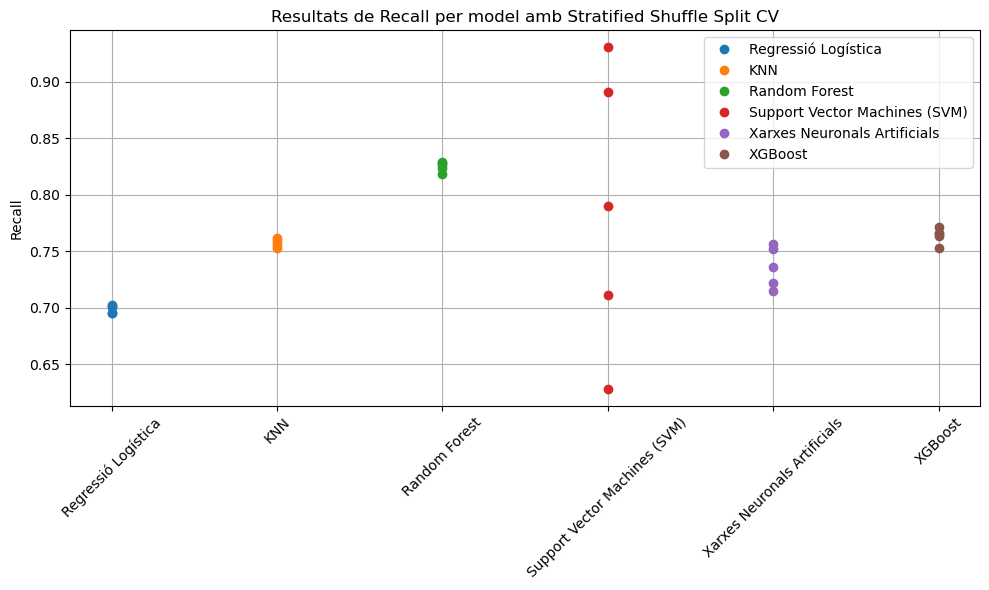

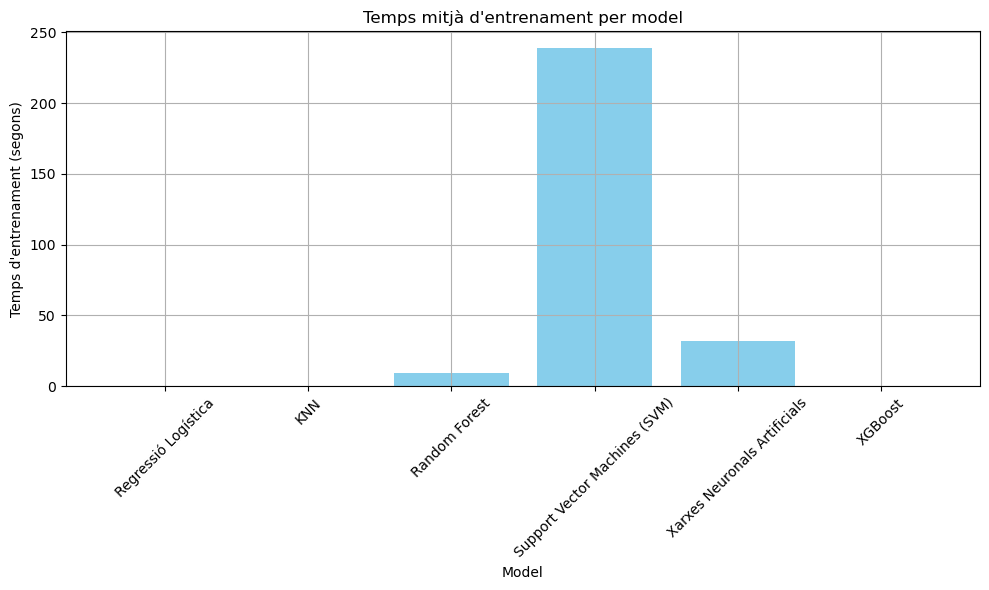

In [40]:
warnings.filterwarnings("ignore", category=ConvergenceWarning) # Silenciem els Warning de convergència del Regressor Logístic

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42) # Per entrenar 5 splits amb el 80% de les dades de X_train_val

recall_results = {model_name: [] for model_name in models.keys()}

training_times = {model_name: [] for model_name in models.keys()}

best_models = {}

for model_name, model in models.items():
    
    best_model = None
    best_recall = 0
    
    for train_cv_index, validation_index in sss.split(X_train_val, y_train_val):
        
        X_train_cv, X_validation_cv = X_train_val.iloc[train_cv_index], X_train_val.iloc[validation_index]
        y_train_cv, y_validation_cv = y_train_val.iloc[train_cv_index], y_train_val.iloc[validation_index]
        
        start_time = time.time()
        
        model.fit(X_train_cv, y_train_cv) # ENTRENAMENT DEL MODEL
        
        training_times[model_name].append(time.time()-start_time) # GUARDEM EL TEMPS D'ENTRENAMENT
    
        y_pred_cv = model.predict(X_validation_cv) # PREDICCIONS
        
        recall = recall_score(y_validation_cv, y_pred_cv) # CÀLCUL DEL RECALL
    
        recall_results[model_name].append(recall) # GUARDEM EL RESULTAT
        
        if recall > best_recall: # GUARDEM EL MODEL AMB MILLOR RECALL DE CADA TIPUS DE MODEL
            best_recall = recall
            best_model = model
    
    best_models[model_name] = best_model
    
    print("Validació de " + model_name + " completada.")


# VISUALITZACIÓ GRÀFICA DELS RESULTATS

plt.figure(figsize=(10, 6))
for model_name, recall_list in recall_results.items():
    plt.plot([model_name] * len(recall_list), recall_list, 'o', label=model_name)
plt.title('Resultats de Recall per model amb Stratified Shuffle Split CV')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

avg_training_times = {model_name: sum(times) / len(times) for model_name, times in training_times.items()}

plt.figure(figsize=(10, 6))
plt.bar(avg_training_times.keys(), avg_training_times.values(), color='skyblue')
plt.title('Temps mitjà d\'entrenament per model')
plt.xlabel('Model')
plt.ylabel('Temps d\'entrenament (segons)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
for model_name, temps in training_times.items():
    print ("Temps mitjà d'entrenament de " + model_name + ": " + str(np.mean(temps)) + " segons")

Temps mitjà d'entrenament de Regressió Logística: 0.07590255737304688 segons
Temps mitjà d'entrenament de KNN: 0.12442340850830078 segons
Temps mitjà d'entrenament de Random Forest: 8.952877426147461 segons
Temps mitjà d'entrenament de Support Vector Machines (SVM): 238.87149662971495 segons
Temps mitjà d'entrenament de Xarxes Neuronals Artificials: 31.728519344329833 segons
Temps mitjà d'entrenament de XGBoost: 0.17864646911621093 segons


In [68]:
# AQUESTA CELDA SERVEIX PER GUARDAR ELS MODELS ENTRENATS I NO HAVER-LOS D'ENTRENAR CONTINUAMENT

import pickle

variables_a_guardar = {"models": models, "best_models": best_models, "training_times": training_times}

with open('variables.pkl', 'wb') as f:
    pickle.dump(variables_a_guardar, f)

La primera impresió que ens donen els resultats d'aquest experiment és bastant evident: el Support Vector Machines presenta molta variància en el Recall (ha sigut, al mateix temps, el millor i pitjor model dels sis), això pot denotar que té molta sensibilitat o als subconjunts amb els quals s'entrena o al subconjunt que prediu o a les dues coses. 

Veiem que un dels 5 models SVM que s'han entrenat ha arribat a aconseguir un recall de gairebé 100%. Això no vol dir que sigui un bon model, ja que podria estar cometent errors greus, com classificar totes les mostres com a positives.

Per obtenir més informació sobre el que està passant amb els SVM, podem mostrar la matriu de confusió i la corba PR del millor model (el que ha obtingut aprop del 100% de Recall). Utilitzarem els subconjunts de validació que hem extret abans del conjunt d'entrenament, i que no hem fet servir per realitzar la validació creuada anterior.

-------------------------
>>> Rendiment del model:
- Accuracy: 0.616
- Precision: 0.597
- Recall (Sensitivity, TPR): 0.712
- Fallout (1-Specificity): 0.48
- F1: 0.65
-------------------------


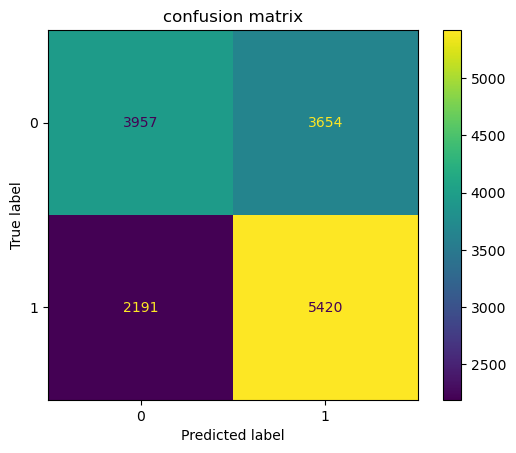

{'acc': 0.6160162922086454,
 'prec': 0.5973109984571303,
 'rec': 0.7121271843384575,
 'f1': 0.6496853461192689,
 'fallout': 0.4800945999211667}

In [69]:
show_performance(X_validation, y_validation, best_models["Support Vector Machines (SVM)"])

Podem observar que, efectivament, el SVC no està funcionant correctament, ja que el mateix model que abans ha obtingut un 97% de recall, ara obté tan sols un 71%. Això vol dir que el rendiment del model no depèn de com s'hagi entrenat, sinó del conjunt de dades que prediu. Pot ser que el conjunt de validació que s'ha utilitzat abans tingués les variables molt desbalancejades, i el SVC les hagi classificat totes com a positives, aconseguint així el 100% de Recall, però és igual, perquè no hi ha cap dubte que aquest SVC és un model poc fiable i sense molta capacitat de generalització.

Això pot tenir diverses causes, entre les quals:

-Desbalanceig de classes: Encara que hem equilibrat parcialment les classes durant el Preprocessing, la diferència de proporcions continua éssent gran (recordem que la classe 1 de la variable "gluc" representava un 65% del total de les mostres, després del Preprocessing).

-Paràmetres del model: Hem instanciat el SVC amb els paràmetres per defecte, llavors, pot ser que aquests paràmetres no siguin els adequats per complir amb les necessitats del model en aquest dataset concret.

-Selecció de característiques: Si hi ha característiques inútils, el SVC pot no ser capaç de trobar patrons útils entre les dades. Recordem que, durant [l'EDA](#1.-Exploratory-Data-Analysis), vam observar que hi havia característiques ("smoke", "alco" i "active") que no tenien gairebé cap impacte en el target i que a més podien causar "misleading".

-Necessitat de convergir: Al haver posat un màxim de 6000 iteracions, potser el SVC no ha pogut convergir i per això hem tingut aquests mals resultats. Sigui com sigui, el temps d'entrenament ha sigut molt superior al dels altres models.

-Theshold no adequat: Si ens fixem en la matriu de confusió, observem que s'està classificant un 50% més de mostres positives que de negatives. Això pot voler dir que el threshold per defecte (0.5) no és el millor. Podem mostrar la corba PR per veure si la deficiència del model es tracta realment o no del threshold: 

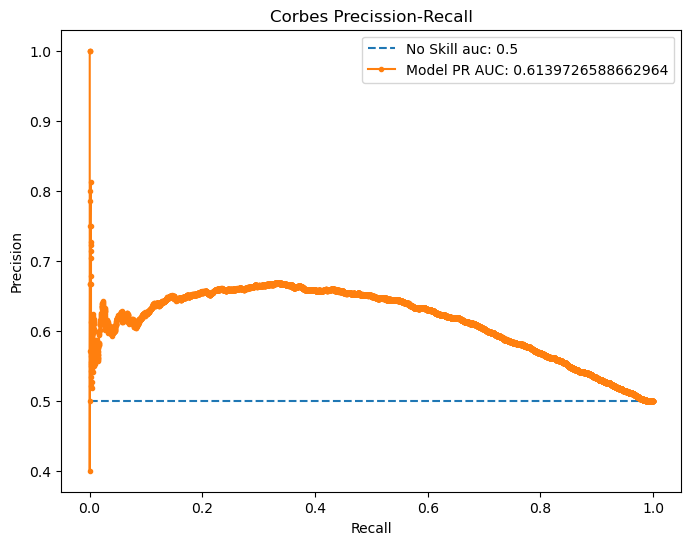

In [45]:
mostrarPR(X_validation, y_validation, best_models["Support Vector Machines (SVM)"])

Podem observar que la corba PR és molt pobre (només té un 60% d'àrea sota la corba). Vam comentar durant l'apartat de [Metrics](#3.-Metrics) que, malgrat que buscàvem el millor Recall possible, també havíem de tenir en compte que un classificador inútil que classifiqués totes les mostres com a positives donaria un 100% de Recall, i llavors no ens podíem fiar només del Recall, també hauríem de vigilar que la precision no caigués molt (el que ens està passant aquí és algo similar, el recall és 0.7 i el precision 0.59, ja que està classificant masses mostres com a positives). Per tal de trobar un threshold que balanceji al mateix temps tant el Precision com el Recall, podem utilitzar la mètrica F1-Score.

In [62]:
probs = best_models["Support Vector Machines (SVM)"].predict_proba(X_validation)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_validation, probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]
best_f1 = f1_scores[f1_scores.argmax()]
print(f"Millor threshold: {best_threshold}, F1 per al millor threshold: {best_f1}")

Millor threshold: 0.6315435634854298, F1 per al millor threshold: 0.6699571243394156


In [63]:
predictions = (probs >= best_threshold).astype(int)
recall = recall_score(y_validation, predictions)
precision = precision_score(y_validation, predictions)
accuracy = accuracy_score(y_validation, predictions)
print("Recall: " + str(recall))
print("Precision: " + str(precision))
print("Accuracy: " + str(accuracy))

Recall: 0.8828012087767705
Precision: 0.5398087892664899
Accuracy: 0.5651031401918276


Com podem observar, per al millor threshold de la mètrica F1-Score, que suposadament hauria de balancejar Recall i Precision alhora, obtenim un Recall de 0.88 per a una Precision de 0.54. Això no és el que buscàvem, perquè significa que està actuant de manera similar a com ho faria un classificador aleatòri (encara que una mica millor).

SVM és un model sensible als seus hiperparàmetres, per tant, estem segurs que si trobéssim els millors hiperparàmetres per al SVM mitjançant un Randomized Search o Grid Search, el rendiment milloraria. Tot i això, és un model molt ineficent en termes de temps (tarda casi 250 segons en entrenar-se, mentre les Xarxes Neuronals només tarden 30 segons), i ja tenim altres models que ens ofereixen bons resultats (ho veurem a continuació), per tant, hem decidit descartar els SVM.

D'altra banda, veiem que el Random Forest ha aconseguit resultat bastant bonts (entorn al 83% de Recall). Anem a observar la seva matriu de confusió, per saber si està treballant correctament:

-------------------------
>>> Rendiment del model:
- Accuracy: 0.844
- Precision: 0.858
- Recall (Sensitivity, TPR): 0.824
- Fallout (1-Specificity): 0.136
- F1: 0.841
-------------------------


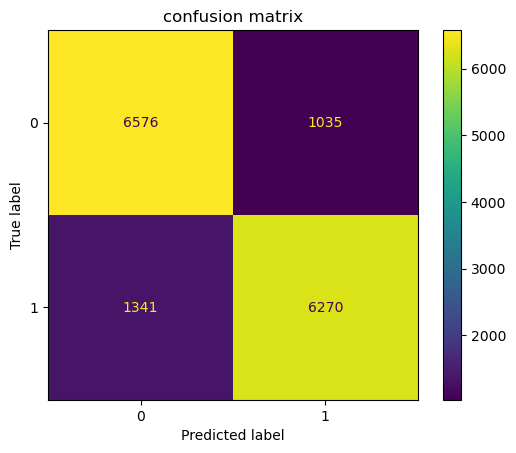

{'acc': 0.8439101300748916,
 'prec': 0.8583162217659137,
 'rec': 0.823807646826961,
 'f1': 0.8407079646017699,
 'fallout': 0.13598738667717777}

In [64]:
show_performance(X_validation, y_validation, best_models["Random Forest"])

Efectivament, veiem que els resultats són bastant bons, i no només per al Recall. Tenint en compte que està utilitzant els paràmetres per defecte i que, per tant, pot millor bastant si trobem els paràmetres adequats -encara que el Random Forest no sigui tan sensible als hiperparàmetres com els altres models-, no descartarem el Random Forest. A més, el temps d'entrenament no ha sigut exageradament gran, com sí que ha sigut els del SVM i de les Xarxes Neuronals.

El XGBoost, éssent un model no tan utilitzat com el Random Forest o les Xarxes Neuronals, ha aconseguit uns bons resultats (entorn al 75%) amb un temps d'entrenament molt inferior al del Random Forest, SVM o Xarxes Neuronals (menys d'un segon), proper al temps que utilitzen els models simples com el KNN o la Regressió Logística. Per tant, tampoc el descartem i passa al següent nivell.

La "gran decepció" d'aquest experiment han sigut les Xarxes Neuronals: malgrat requerir el temps d'entrenament més alt de tots, el seu Recall no ha arribat al 80%.

Però això pot tenir una explicació bastant lògica: les Xarxes Neuronals son més propenses a l'overfitting en comparació amb molts altres models, especialment si s'entrenen sense precaucions adequades. Això és degut a la seva capacitat de modelar relacions complexes i aprendre patrons profunds de les dades.

Per comprovar si realment es tracta d'overfitting, podem mostrar les corbes d'aprenentatge. Recordem que les corbes d'aprenentatge mostren com canvia el rendiment d'un model en funció del nombre de mostres, tant en el conjunt de test com en el de train. Si veiem que en el conjunt d'entrenament el Recall és molt més alt que en el conjunt de prova (recordem que realment no utilitzem el conjunt de prova X_test, sinó el de validació X_validation), llavors es tracta d'un cas d'overfitting.

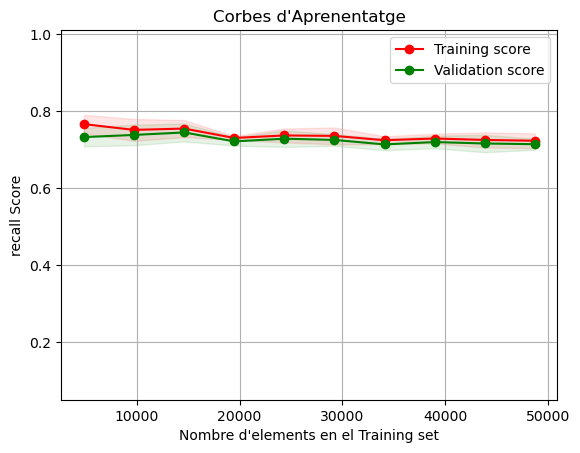

In [73]:
train_sizes, train_scores, val_scores = learning_curve(models["Xarxes Neuronals Artificials"], X_train_val, y_train_val, cv=5, scoring="recall", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
plot_learning_curve(train_sizes, train_scores, val_scores, scoring="recall", ylim=(0.05, 1.01))

Com podem apreciar, no es tracta d'un cas d'Overfitting, ja que els nivells de recall són gairebé els mateixos tant en el conjunt d'entrenament com en el de validació.

Tot i això, sabem que les Xarxes Neuronals Artificials tenen una sensibilitat molt gran als hiperparàmetres, per tant, seguim pensant que el classificador MLP pot donar un gran pas cap endavant si es troben els hiperparàmetres òptims, així que continuarem amb ell i no el descartarem, malgrat que "li donarem un toc d'atenció".

Respecte al KNN, la veritat és que no esperàvem que tingués tant d'èxit: ha arribat a superar el rendiment de les Xarxes Neuronals i del SVM, amb un temps d'entrenament (de memorització, en realitat) molt petit. Aquí podem veure la matriu de confusió del millor model trobat durant la validació creuada:

-------------------------
>>> Rendiment del model:
- Accuracy: 0.766
- Precision: 0.776
- Recall (Sensitivity, TPR): 0.75
- Fallout (1-Specificity): 0.217
- F1: 0.762
-------------------------


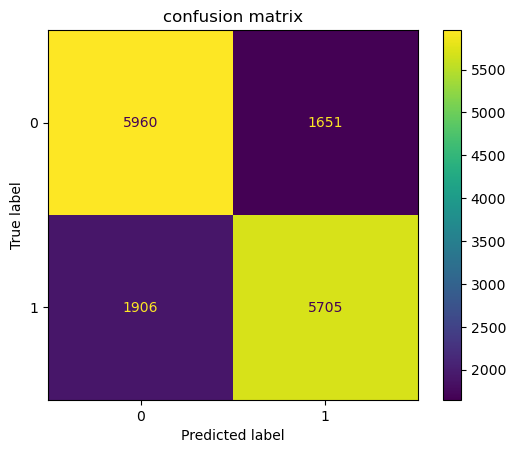

{'acc': 0.7663250558402313,
 'prec': 0.7755573681348559,
 'rec': 0.7495729864669557,
 'f1': 0.7623438230774371,
 'fallout': 0.21692287478649325}

In [72]:
show_performance(X_validation, y_validation, best_models["KNN"])

Podem comprovar que les seves mètriques són bastant bones, i encara que no sigui un model molt sensible als hiperparàmetres (en comparació amb els altres), estem segurs que podem millorar-lo si trobem la combinació correcte.

Respecte al Regressor Logístic, ha actuat tal i com esperàvem: un Recall mitjà del 70%, més baix que el dels altres models (encara que més alt que alguns models del SVM), encara que amb un temps d'entrenament molt baix.

El Regressor Logístic té alguns hiperparàmetres interessants que podríem ajustar, com la regularització (Lasso o Ridge), la 'C' (coeficient de penalització) o 'solver' (funció d'optimització de la funció de pèrdua), però no creiem que pugui arribar als resultats que poden aconseguir els altres models. La intenció de provar el KNN i el Regressor Logístic era veure si per casualitat arribaven a tenir un rendiment similar als models complexos: en el cas del KNN, veiem que sí que es pot apropar, però el Regressor Logístic es queda bastant enrere, per tant, creiem que la millor opció és descartar-lo i enfocar els nostres recursos en intentar millorar al màxim els models seleccionats (Random Forest, KNN, Xarxes Neuronals i XGBoost).

In [74]:
del(models["Regressió Logística"])
del(models["Support Vector Machines (SVM)"])

### Trobar hiperparàmetres amb Randomized Search

El següent pas serà realitzar una cerca randomitzada (Randomized Search) mitjançant validació creuada per trobar els millos hiperparàmetres per als nostres diferents models.

Realitzarem una Randomized Search i no un Grid Search perquè volem que l'espai de cerca sigui gran (per trobar bons hiperparàmetres), llavors, si utilitzéssim Grid Search, la cerca, donats els recursos computacionals que tenim, seria molt lenta (ja que provaria totes les combinacions d'hiperparàmetres possibles), per tant, Randomized Search pot ser més adequada en el nostre cas.

In [77]:
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "KNN": {
        'n_neighbors': list(range(1, 31)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
        'p': [1, 2, 3],                           
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': list(range(10, 51, 5))
    },
    "Xarxes Neuronals Artificials": {
        'hidden_layer_sizes': [(100,), (50, 50), (100, 100), (150,)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam', 'sgd'],
        'learning_rate': ['constant', 'adaptive'],
        'alpha': [0.0001, 0.001, 0.01]
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 6, 10, 12],
        'learning_rate': [0.1, 0.05, 0.01],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'min_child_weight': [1, 2, 3]
    }
}

Millors paràmetres per a KNN: {'weights': 'distance', 'p': 2, 'n_neighbors': 23, 'metric': 'minkowski', 'leaf_size': 25, 'algorithm': 'kd_tree'}
Millors paràmetres per a Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}
Millors paràmetres per a Xarxes Neuronals Artificials: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'relu'}
Millors paràmetres per a XGBoost: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.7}


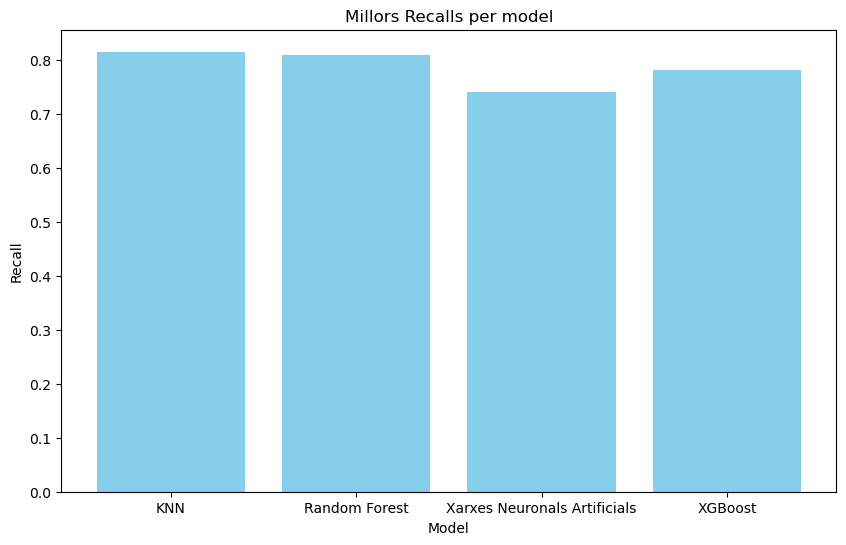

In [78]:
best_models = {}
best_scores = {}

for model_name, model in models.items():
    
    randomized_search = RandomizedSearchCV(  # INSTANCIEM UN RANDOMIZED SEARCH QUE UTILITZARÀ CROSS VALIDATION AMB 5 SPLITS
        estimator=models[model_name],
        param_distributions=param_grids[model_name],
        scoring="recall",
        cv=5,
        n_jobs=-1,
        n_iter=10,
        random_state=42
    )
    
    randomized_search.fit(X_train_val, y_train_val)  # REALITZEM EL RANDOMIZED SEARCH
    
    best_models[model_name] = randomized_search.best_estimator_
    best_scores[model_name] = randomized_search.best_score_
    
    print("Millors paràmetres per a " + model_name + ": " + str(randomized_search.best_params_))
    
# MOSTRAR RESULTATS

plt.figure(figsize=(10, 6))
plt.bar(best_scores.keys(), best_scores.values(), color='skyblue')
plt.title('Millors Recalls per model')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.show()

In [81]:
for model_name, score in best_scores.items():
    print("Recall de " + model_name + ": " + str(score))

Recall de KNN: 0.8144462321814675
Recall de Random Forest: 0.8085335536454548
Recall de Xarxes Neuronals Artificials: 0.740638290456779
Recall de XGBoost: 0.7797923497468238


Podem observar que hem aconseguit una millora important en el KNN (81% ara, 75% abans), mentre que les Xarxes Neuronals Artificials i el XGBoost estan pràcticament com abans (74% i 78%, respectivament), i el Random Forest ha perdut una mica (abans 82%, ara 80%).

Tot i haver realitzat el Randomized Search, de moment el millor model fins ara és el Random Forest amb els paràmetres per defecte.

In [82]:
# CEL·LA PER GUARDAR LES VARIABLES EN UN ARXIU, PER NO TORNAR A EXECUTAR EL RANDOMIZED SEARCH

import pickle

variables_a_guardar = {"models": models, "best_models": best_models, "best_scores": best_scores}

# Serializa solo el diccionario de variables
with open('variablesPas2.pkl', 'wb') as f:
    pickle.dump(variables_a_guardar, f)

Durant la fase d'[EDA](#1.-Exploratory-Data-Analysis) vam mencionar que podria ser beneficiós per als models eliminar les columnes subjectives ("smoke", "alco" i "active") perquè semblaven no tenir cap impacte real en el target i podien provocar "misleading". Ara, com a última prova, validarem els diferents models amb els conjunts de dades sense aquestes columnes (per cada model, amb els millors hiperparàmetres trobats anteriorment), a veure si algun model presenta cap millora considerable:

In [89]:
X_train_val_reduced = X_train_val.drop(["smoke", "alco", "active"], axis=1)
X_validation_reduced = X_validation.drop(["smoke", "alco", "active"], axis=1)

best_models["Random Forest"].fit(X_train_val_reduced, y_train_val)
best_models["KNN"].fit(X_train_val_reduced, y_train_val)
best_models["Xarxes Neuronals Artificials"].fit(X_train_val_reduced, y_train_val)
best_models["XGBoost"].fit(X_train_val_reduced, y_train_val)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

-------------------------
>>> Rendiment del model:
- Accuracy: 0.834
- Precision: 0.85
- Recall (Sensitivity, TPR): 0.812
- Fallout (1-Specificity): 0.143
- F1: 0.831
-------------------------


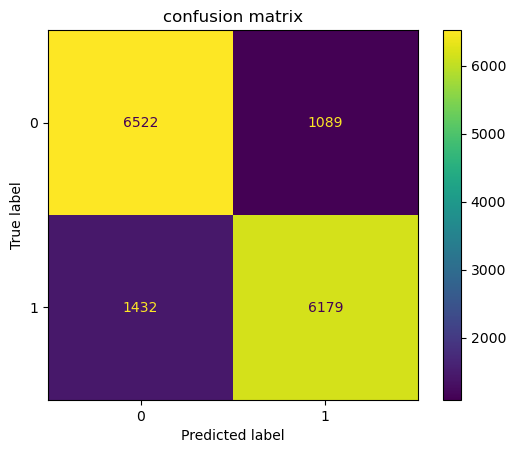

{'acc': 0.8343844435685193,
 'prec': 0.8501651073197578,
 'rec': 0.8118512679017212,
 'f1': 0.8305665703340277,
 'fallout': 0.1430823807646827}

In [90]:
show_performance(X_validation_reduced, y_validation, best_models["Random Forest"])

Per al Random Forest aconseguim una petita millora de 0.03 en el Recall respecte al model amb els "millors hiperparàmetres" trobats per Randomized Search, però continua éssent pitjor que el Random Forest amb els hiperparàmetres per defecte. Anem a veure un R.F. per defecte amb els datasets sense variables subjectives:

-------------------------
>>> Rendiment del model:
- Accuracy: 0.843
- Precision: 0.857
- Recall (Sensitivity, TPR): 0.824
- Fallout (1-Specificity): 0.138
- F1: 0.84
-------------------------


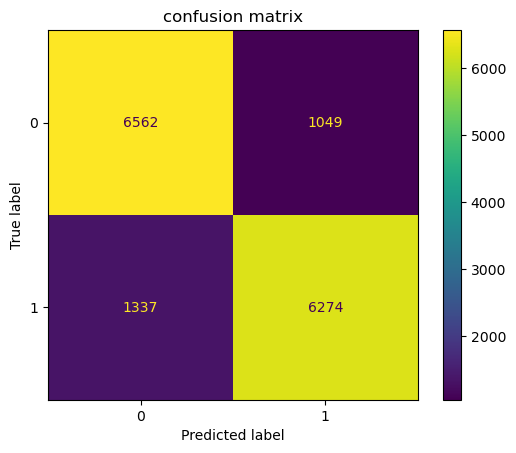

{'acc': 0.8432531861779005,
 'prec': 0.8567526969821112,
 'rec': 0.824333201944554,
 'f1': 0.8402303468595154,
 'fallout': 0.1378268295887531}

In [94]:
model_rf = RandomForestClassifier() # INSTANCIEM RF AMB PARÀMETRES PER DEFECTE
model_rf.fit(X_train_val_reduced, y_train_val)
show_performance(X_validation_reduced, y_validation, model_rf)

Observem que no canvia gairebé res del Random Forest que vam entrenar amb els datasets amb variables subjectives.

Veiem ara el KNN amb els datasets reduïts:

-------------------------
>>> Rendiment del model:
- Accuracy: 0.847
- Precision: 0.868
- Recall (Sensitivity, TPR): 0.819
- Fallout (1-Specificity): 0.125
- F1: 0.843
-------------------------


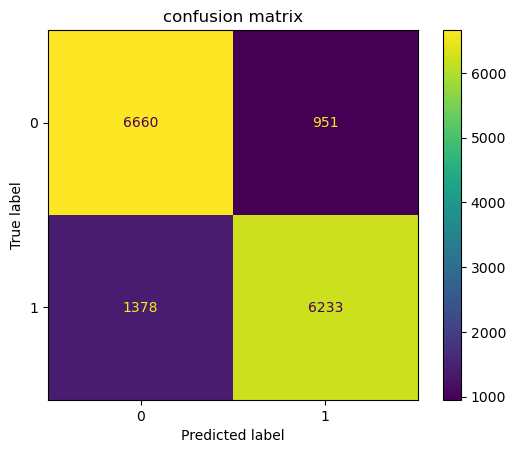

{'acc': 0.8469977663907502,
 'prec': 0.8676224944320713,
 'rec': 0.8189462619892262,
 'f1': 0.8425819533626225,
 'fallout': 0.12495072920772567}

In [95]:
show_performance(X_validation_reduced, y_validation, best_models["KNN"])

Continua pràcticament igual que com estava amb les variables subjectives.

Com que sembla que no canvia en cap cas, ara anem a mirar els dos últims models més ràpidament, sense mostrar la matriu de confusió i mirant directament el Recall:

In [100]:
y_pred = best_models["Xarxes Neuronals Artificials"].predict(X_validation_reduced)
print("Recall per X.N.A. sense variables subjectives: ", recall_score(y_validation, y_pred))

Recall per X.N.A. sense variables subjectives:  0.7238207857049008


In [101]:
y_pred = best_models["XGBoost"].predict(X_validation_reduced)
print("Recall per XGBoost sense variables subjectives: ", recall_score(y_validation, y_pred))

Recall per XGBoost sense variables subjectives:  0.7774274076993825


Podem observar que, efectivament, els canvis entre entrenar els models amb i sense les variables subjectives són mínims (una mica pitjors si no incluim aquestes variables). Per tant, continuarem utilitzant els datasets que contenen aquestes variables, com hem anat fent fins ara.

Com ja hem comentat fa un moment, el Random Forest amb els paràmetres per defecte (aquests són, entre d'altres: 100 estimadors, criteri gini, sense profunditat màxima...) ha sigut el que millors resultats ens ha donat (sobre el 83% de Recall), però el KNN amb els paràmetres que hem tret amb el Randomized Search ({'weights': 'distance', 'p': 2, 'n_neighbors': 23, 'metric': 'minkowski', 'leaf_size': 25, 'algorithm': 'kd_tree'}) el segueixen molt d'aprop (82% de Recall).

Els altres dos models (Xarxes Neuronals Artificials i XGBoost) estan una mica enrere, i per tant els descartem.

Ara, llavors, abans de decantar-nos per un o altre model, anem a veure si els podem millorar ajustant el seu threshold.

Anem a mostrar a continuació les corbes PR i ROC del Random Forest amb els paràmetres per defecte:

#### COMPARACIÓ FINAL

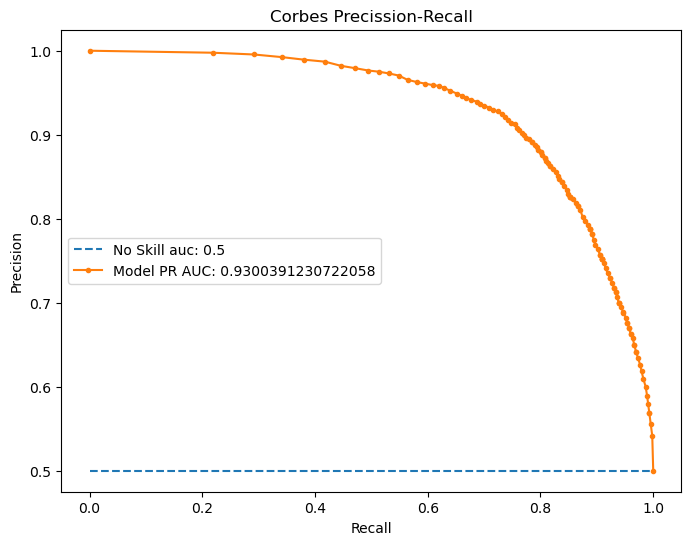

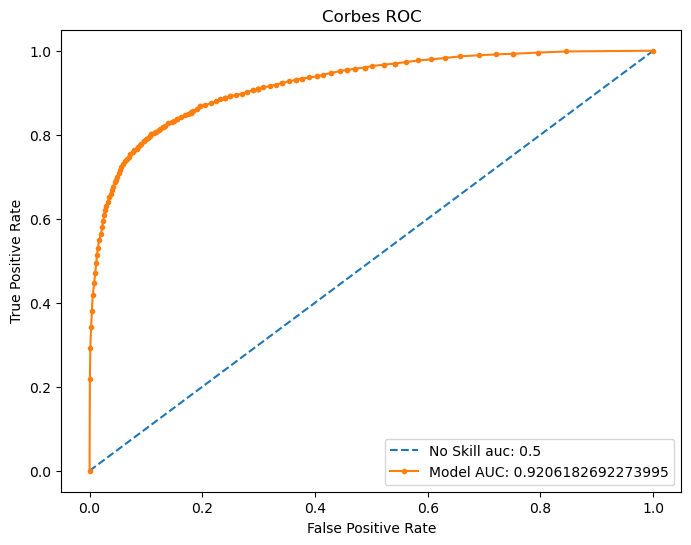

In [105]:
best_models["Random Forest"] = RandomForestClassifier()

best_models["Random Forest"].fit(X_train_val, y_train_val)

mostrarPR(X_validation, y_validation, best_models["Random Forest"])
mostrarROC(X_validation, y_validation, best_models["Random Forest"])

D'aquestes dues corbes podem obtenir la següent informació:

a) L'AUC de la corba PR és molt proper a 1 (0.93): El model té una alta precisió i recall, és a dir, identifica correctament els positius i no genera molts falsos positius.

b) L'AUC de la corba ROC és molt proper a 1 (0.92): El model és capaç de distingir la classe positiva de la negativa.

Fem el mateix per al KNN amb els paràmetres trobats per Randomized Search:

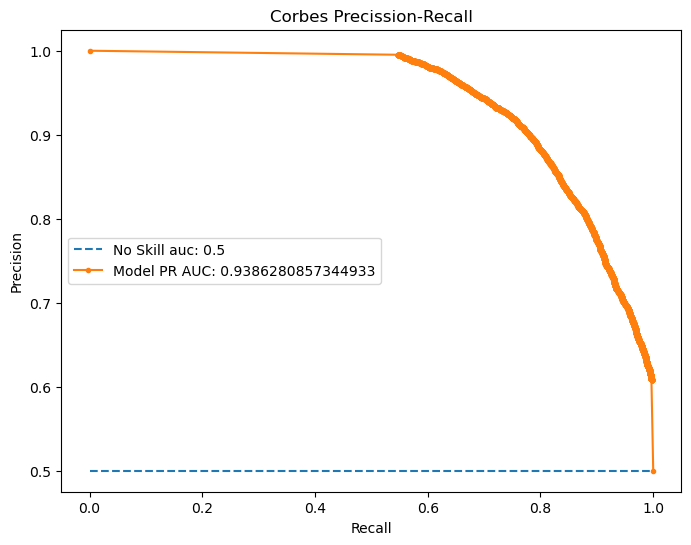

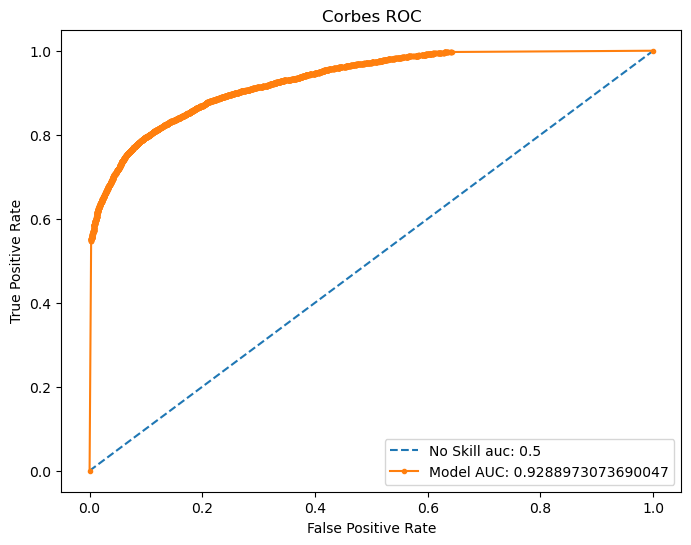

In [125]:
best_models["KNN"].fit(X_train_val, y_train_val)

mostrarPR(X_validation, y_validation, best_models["KNN"])
mostrarROC(X_validation, y_validation, best_models["KNN"])

Podem observar que el KNN té millors àrees sota la corva, tant per a la PR com per a la ROC. Això pot ser un indicatiu que aquest model és millor que el Random Forest.

L'últim que ens queda ara és trobar el threshold de cada model que ens permeti maximitzar el número de true positives sense que el número de false positives sigui extremadament alt. Recordem que en el nostre treball estem donant prioritat a la detecció de true positives (als malalts de CVDs, per poder-los tractar quan abans millor), però tampoc volem que el model classifiqui a tots els pacients com true positives (si ho fés, el model no tindria cap sentit, i els centres mèdics quedarien col·lapstats), llavors haurem de jugar amb el trade-off Precision-Recall per trobar el millor Recall dins d'un rang de Precision acceptable.

Per fer-ho, a l'apartat [Metrics](#3.-Metrics) vam definir una funció que permetia trobar el threshold d'un model amb el qual s'obté el màxim recall donat un precision mínim. Utilitzarem ara aquesta funció per trobar els millors thresholds.

Però abans hem de definir un precision mínim. Aquest valor és important, perquè farà que el número de false positives i true positives canviï. Estem buscant un número gran de true positives, però sense obtenir un false positives massa gran, per tant, podríem provar amb un precision de 0.75 (això significa que de cada 4 diagnòstics positius, 3 seran correctes). Aquest valor es pot anar canviant en funció del centre mèdic on es vulgui aplicar aquest model, depenent de la seva demanda i capacitat (si tenen molta capacitat, es poden permetre més false positives a canvi d'obtenir més true positives).

Millor threshold per a Random Forest: 0.2833333333333333 amb recall: 0.9090789646564184
Millor threshold per a KNN: 0.2714974724681043 amb recall: 0.9140717382735515


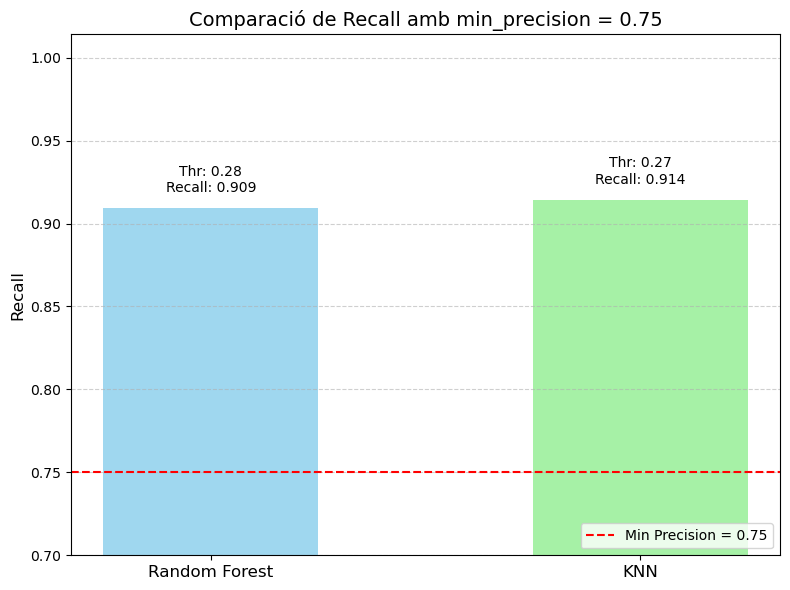

In [136]:
min_precision = 0.75

threshold_RandomForest, best_recall_RandomForest, _ = find_best_threshold_with_min_precision(best_models["Random Forest"], X_validation, y_validation, min_precision)

threshold_KNN, best_recall_KNN, _ = find_best_threshold_with_min_precision(best_models["KNN"], X_validation, y_validation, min_precision)

print("Millor threshold per a Random Forest: " + str(threshold_RandomForest) + " amb recall: " + str(best_recall_RandomForest))
print("Millor threshold per a KNN: " + str(threshold_KNN) + " amb recall: " + str(best_recall_KNN))

models_name = ['Random Forest', 'KNN']
recall_scores = [best_recall_RandomForest, best_recall_KNN]
thresholds = [threshold_RandomForest, threshold_KNN]
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(models_name, recall_scores, color=['skyblue', 'lightgreen'], alpha=0.8, width=0.5)
for bar, recall, threshold in zip(bars, recall_scores, thresholds):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, 
            f"Thr: {threshold:.2f}\nRecall: {recall:.3f}", 
            ha='center', fontsize=10, color='black')
ax.set_ylim(min_precision - 0.05, max(recall_scores) + 0.1)
ax.set_ylabel('Recall', fontsize=12)
ax.set_title(f'Comparació de Recall amb min_precision = {min_precision}', fontsize=14)
ax.axhline(y=min_precision, color='red', linestyle='--', label=f'Min Precision = {min_precision}')
ax.legend(loc='lower right')
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Podem observar que els dos models tenen un Recall pràcticament igual, i per tant, podríem declarar-ho com a empat, o realitzar més proves per determinar quin és el veritable guanyador. De totes maners, com que el KNN ha guanyar al Random Forest per 5 centèssimes, direm que **el millor model és el KNN**, ja que els dos són molt iguals i realitzar més proves ens consumiria molt més temps.

Tot i així, podria ser que realitzant una cerca amb més iteracions amb el Randomized Search, o una cerca exhaustiva amb el Grid Search, es trobessin hiperparàmetres que fessin millorar als models i canviar el resultat.

Per últim en aquesta secció, anem a mirar si els nostres dos models finals tenen overfitting (de nou amb les corbes d'aprenentatge) i, en cas que en tinguin, donar algunes idees sobre com es podrien equilibrar.


Corbes d'aprenentatge per al Random Forest:

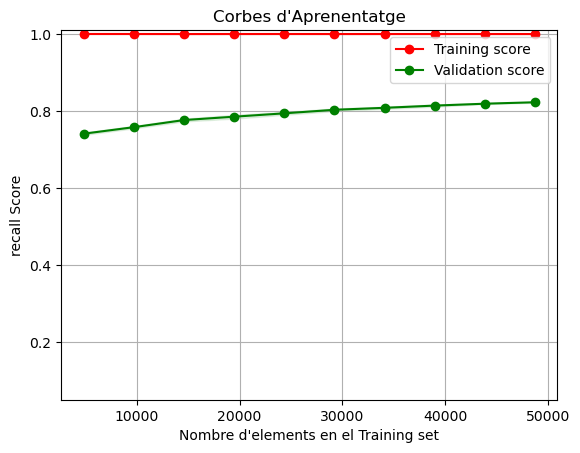

In [147]:
train_sizes, train_scores, val_scores = learning_curve(best_models["Random Forest"], X_train_val, y_train_val, cv=5, scoring="recall", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
plot_learning_curve(train_sizes, train_scores, val_scores, scoring="recall", ylim=(0.05, 1.01))

Veiem que el recall per al conjunt d'entrenament és al voltant d'un 20% superior al recall del conjunt de validació, per tant, sí que en té una mica d'overfitting (encara que no és exagerat).

Per evitar-ho, algunes tècniques bàsiques i comunes són:

-Reduïr la profunditat màxima dels arbres (max_depth)

-Limitar el nombre mínim de mostres per fulla (min_samples_leaf)

-Limitar el nombre mínim de mostres per a dividir un node (min_samples_split)

Corbes d'aprenentatge per al KNN:

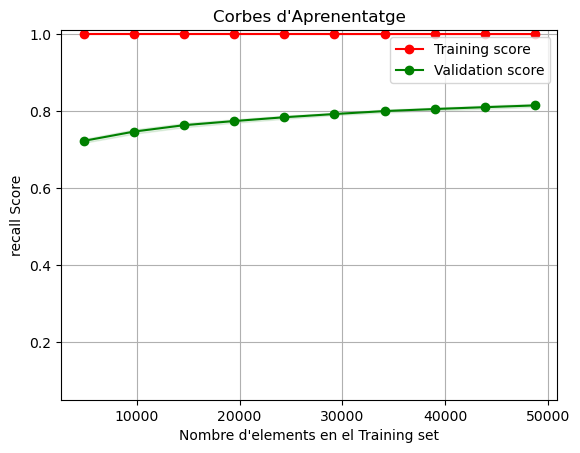

In [138]:
train_sizes, train_scores, val_scores = learning_curve(best_models["KNN"], X_train_val, y_train_val, cv=5, scoring="recall", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
plot_learning_curve(train_sizes, train_scores, val_scores, scoring="recall", ylim=(0.05, 1.01))

Veiem que són pràcticament iguals a les del Random Forest: té una mica d'overfitting, que es podria neutralitzar utilitzant aquestes tècniques:

-Augmentar el nombre de veïns (k)

-Aplicar una PCA a les dades per reduir l'espai de característiques


I de manera general per als dos models:

-Proporcionar més dades d'entrenament

-Utilitzar un subconjunt de característiques

-Trobar millors combinaciosn d'hiperparàmetres mitjançant Grid Search o Randomized Search

## 5. Resultats finals

En aquest apartat utilitzarem el conjunt de Test per avaluar definitivament el model seleccionat a l'apartat anterior: el **KNN**.

Recordem que els millors hiperparàmetres trobats durant la Randomized Search han estat els següents:

{'weights': 'distance', 'p': 2, 'n_neighbors': 23, 'metric': 'minkowski', 'leaf_size': 25, 'algorithm': 'kd_tree'}

I el millor threshold (per a una precisió mínima de 0.75) és: 0.27

Primer de tot, definim i entrenem el model:

In [149]:
knn = KNeighborsClassifier(n_neighbors=23, weights='distance', p=2, metric='minkowski', leaf_size=25, algorithm='kd_tree')

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=25, n_neighbors=23,
                     weights='distance')

Ara predim probabilitats i mostrem resultats finals:

Accuracy: 0.6678779069767442
Precision: 0.6207716416297417
Recall: 0.8440852314474651


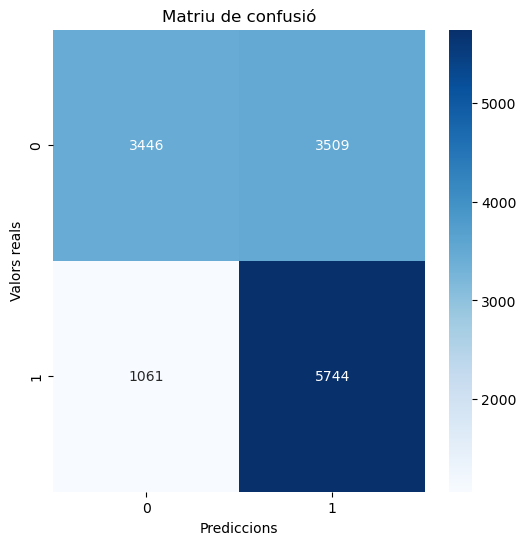

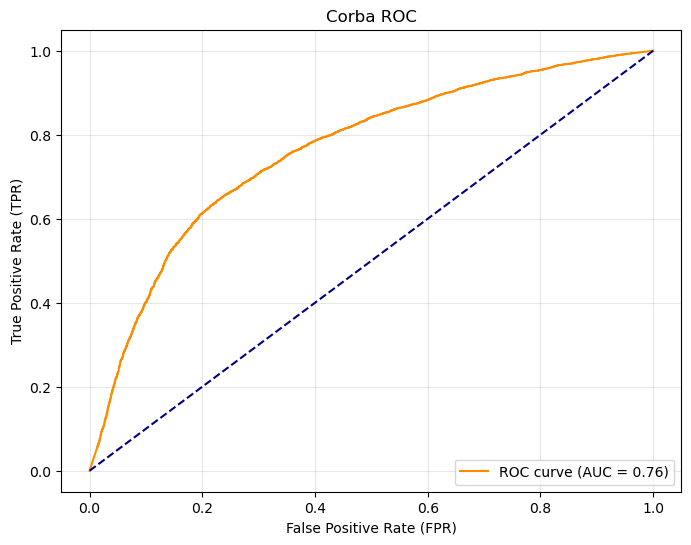

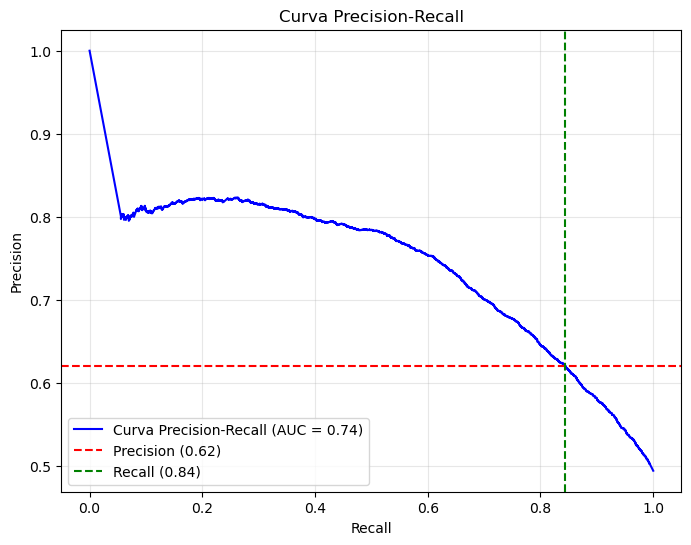

In [163]:
probs = knn.predict_proba(X_test)[:, 1] # PREDIR PROBABILITATS (NO PODEM FER predict QUAN TENIM UN THRESHOLD PERSONALITZAT)

threshold = 0.27

predictions = (probs >= threshold).astype(int)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

mostrar_resultat_final(y_test, predictions, probs)

Podem observar que els resultats no són igual de bons que els que hem vist a la validació, lo qual pot estar passant per una mala distribució de les dades quan hem fet el primer train-test split, ja que dades amb uns valors de features concrets poden haver-se quedat en el train, i uns altres valors de features amb diferent distribució poden haver-se anat cap al test. Per evitar-ho, podríem haver fet més splits durant les validacions creuades que hem anat fent (en totes hem fet 5 splits, podríem haver provat amb 10 o 15, però el temps d'entrenament hauria crescut molt).

Sigui com sigui, la mètrica principal, el Recall, continua éssent alta, un 84%: això vol dir que, de cada 100 pacients que tinguin una malaltia cardiovascular (o tinguin risc de desenvolupar-la en curt termini), en podrem diagnosticar 84.

D'altra banda, el precision és 0.62, això vol dir que, de cada 10 pacients que siguin diagnosticats amb una malaltia cardiovascular, la realitat és que només 6 la tindran. Això depèn en gran part del threshold, i recordem que es pot ajustar depenent de les capacitats del centre mèdic (quants falsos positius es poden permetre).

Els AUCs de les corbes ROC i PR també han baixat respecte a l'etapa anterior, però els valors de 0.76 i 0.74 tampoc són gens dolents.

A continuació podem veure informació dels pacients que ha tractat el nostre KNN:

C:\Users\andre\AppData\Local\Temp\ipykernel_18356\3060745215.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_X_all['Probability'] = probs[all_indices][sorted_indices]


            age  gender  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  \
49961 -0.964842       2    0.0    0.0            2     1      0     0       1   
55873 -1.885448       1   -0.5    0.0            1     1      0     0       1   
3406  -0.600488       2   -0.5   -2.0            1     2      0     0       1   
22409 -2.117874       2    0.0    0.0            1     1      1     1       1   
21785 -2.088924       1   -0.5   -2.0            1     1      0     0       0   
...         ...     ...    ...    ...          ...   ...    ...   ...     ...   
6885   0.950397       1    1.0    1.0            3     3      0     0       1   
55619  1.514919       2    2.0    1.0            3     3      0     0       1   
3823   0.653041       1    1.5    2.0            3     3      0     0       1   
58522  1.196884       1    1.5    1.0            2     2      0     0       1   
54854 -0.782872       1    1.0    0.0            3     3      0     0       1   

            BMI  Probabilit

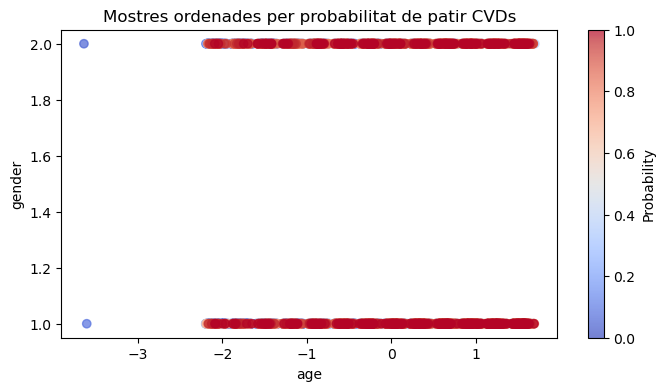

In [175]:
all_indices = np.arange(len(probs))
X_all = X_test.iloc[all_indices]
sorted_indices = np.argsort(probs[all_indices])
sorted_X_all = X_all.iloc[sorted_indices]
sorted_X_all['Probability'] = probs[all_indices][sorted_indices]
print(sorted_X_all)
plt.figure(figsize=(8, 4))
plt.scatter(sorted_X_all.iloc[:, 0], sorted_X_all.iloc[:, 1], 
            c=sorted_X_all['Probability'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Probability')
plt.xlabel('age')
plt.ylabel('gender')
plt.title('Mostres ordenades per probabilitat de patir CVDs')
plt.show()

Sembla que els joves tenen menys probabilitat de patir CVDs, però el gènere no té cap efecte.

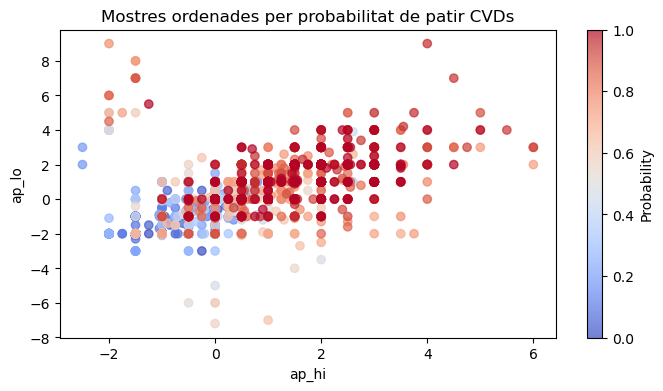

In [177]:
plt.figure(figsize=(8, 4))
plt.scatter(sorted_X_all.iloc[:, 2], sorted_X_all.iloc[:, 3], 
            c=sorted_X_all['Probability'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Probability')
plt.xlabel('ap_hi')
plt.ylabel('ap_lo')
plt.title('Mostres ordenades per probabilitat de patir CVDs')
plt.show()

Podem apreciar que les persones amb alts nivells de ap_hi o de ap_lo (o de les dues) tenen més probabilitats de patir CVDs.

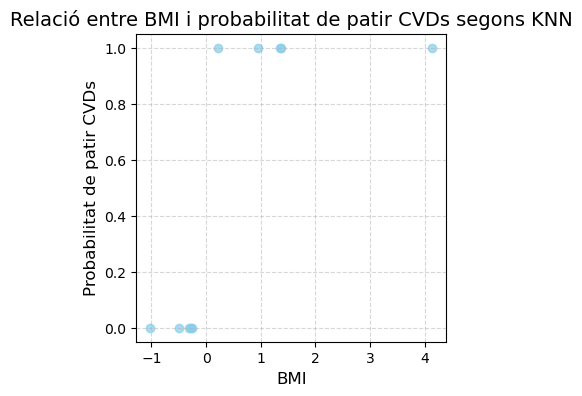

In [5]:
import matplotlib.pyplot as plt


# AQUESTA DATA SURT DE LES 2 ÚLTIMES COLUMNES DEL describe QUE HEM FET MÉS AMUNT
data = {"BMI": [-0.268469, -1.017429, -0.255396, -0.308565, -0.489953,
                1.371195, 0.951173, 4.137837, 0.225800, 1.346923],
        "Probability": [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


plt.figure(figsize=(4, 4))
plt.scatter(data['BMI'], data['Probability'], alpha=0.7, color='skyblue')
plt.title('Relació entre BMI i probabilitat de patir CVDs segons KNN', fontsize=14)
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Probabilitat de patir CVDs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Si comparem els 5 valors amb menys probabilitat de patir CVDs (tots 0%), i els 5 valors amb major probabilitat de patir CVDs (tots 100%), podem observar que clarament, les mostres amb 0% tenen un IMC baix, i les mostres amb 100% tenen un IMC entre normal i molt alt. Per tant, (com ja podíem imaginar al principi), hi ha una relació entre l'IMC i la probabilitat de patir CVDs.

## 6. Conclusions

1. Hem aconseguit construir un model KNN amb unes bones mètriques que permet diagnosticar el 84% dels malalts de malalties cardiovasculars.

2. Hem determinat que els models Random Forest i KNN són pràcticament igual de bons per a predir malalties cardiovasculars, amb una diferència de recall mínima.

3. El pitjor model ha sigut el SVM, juntament amb la Regressió Logística.

4. Les variables subjectives (si el pacient fuma, fa esport, és actiu...) no ens serveixen per predir si un pacient té o no una malaltia cardiovascular. Però això no vol dir que no tinguin relació: potser les dades no estaven ben preses, o el pacient ha mentit sobre els seus hàbits.

5. Les variables que més pes semblen tenir són les variables d'anàlisi (pressió sistòlica ap_hi, pressió diastòlica ap_lo, colesterol i glucosa en sang, etc).

6. Sembla que les variables objectives (com el gènere o l'edat) no tenen molt a veure amb el fet de patir o no una malaltia cardiovascular.

7. Moltes dades mèdiques tenen incongruències (nivells de pressió sanguínis negatius, per exemple) que dificulten el desenvolupament de models d'aprenentatge computacional.


Dit això, esperem que aquest treball compleixi el seu objectiu i ajudi a prevenir el desenvolupament de malalties cardiovasculars i a millorar l'eficiència dels recursos sanitaris.

### Referències i bibliografia

[1]. https://www.cdc.gov/tobacco/campaign/tips/spanish/enfermedades/tabaquismo-enfermedades-cardiacas-accidentes-cerebrovasculares.html *El tabaquismo y las enfermedades cardiacas, los accidentes cerebrovasculares y la enfermedad arterial periférica.*

[2]. https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds) *Cardiovascular diseases (CVDs)*